In [32]:
import numpy as np
from qutip import *
from qutip.qip.operations import rx
import scipy as sp
from scipy.optimize import curve_fit,fsolve
from scipy.special import erfc,erf
import os
import sys
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as sc

In [33]:
from pyfonts import load_font
mpl.rcParams['mathtext.fontset']='cm'
font = load_font(
   font_url="https://github.com/openmaptiles/fonts/blob/master/roboto/Roboto-Regular.ttf?raw=true"
)

#plt.rcParams['font.family'] = 'Roboto Regular'

### Fig. 1 (Summary)

In [ ]:
Ncav = 400
aOp = destroy(Ncav)
aOp1=aOp.dag()
nOp=aOp1*aOp
i=2
xOp=(aOp+aOp1)/2
pOp=(-1j)*(aOp-aOp1)/2
g=basis(2,0)
e=basis(2,1)
px=(g+e).unit()
mx=(g-e).unit()
py=(g+1j*e).unit()
my=(g-1j*e).unit()
meas_px=tensor(qeye(Ncav),ket2dm(px))
meas_g=tensor(qeye(Ncav),ket2dm(g))
meas_mx=tensor(qeye(Ncav),ket2dm(mx))
meas_e=tensor(qeye(Ncav),ket2dm(e))
U=(1j*(np.pi/2)*aOp1*aOp).expm()
U1=U.dag()   
alpha=6
#state=coherent(Ncav,alpha)
#state=displace(Ncav,alpha)*basis(Ncav,0)
state=((-2j*alpha*pOp).expm())*basis(Ncav,0)
print(expect(xOp,state))

5.811176578451143


/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_5883/895064608.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c1=1/np.trapz(np.array(psi1),eigenvals)


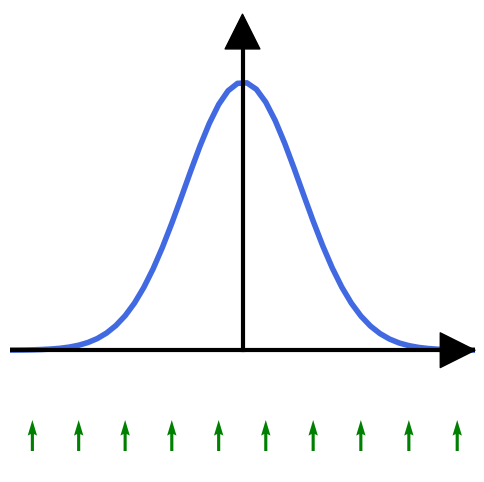

In [35]:
#Ncav=400?
eigenvals,eigenstat=xOp.eigenstates()
eigenvals1,eigenstat1=pOp.eigenstates()
axis_x=[]
psi1=[]
sx=[]
sy=[]
sz=[]
alpha=5
delta=1
chi=-np.pi/4/alpha
Opx=tensor(1j*chi*xOp,sigmax()).expm()
Opy=tensor(1j*chi*pOp,sigmay()).expm()
State=ket2dm((tensor(coherent(Ncav,alpha),g)).unit())#initial state
for i in range(len(eigenstat)):
    Op1=tensor(ket2dm(eigenstat[i]),qeye(2))
    new_State=Op1*State*Op1.dag()
    mod_Qubit=new_State.ptrace(1).unit()
    mod_State=new_State.ptrace(0).unit()
    axis_x.append(eigenvals[i])
    psi1.append(expect(ket2dm(eigenstat[i]),(State.ptrace(0))))
    sx.append(expect(sigmax(),mod_Qubit))
    sy.append(expect(sigmay(),mod_Qubit))
    sz.append(expect(sigmaz(),mod_Qubit))
c1=1/np.trapz(np.array(psi1),eigenvals)
psi1=c1*np.array(psi1)    
fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(alpha-2,alpha+2)
ax.axis("off")
ax.plot(axis_x,psi1,color="royalblue",linewidth=4,label=r"$|\psi(x)|^2$")
ax.annotate("",xy=(7.0, 0), xytext=(6.6, 0),arrowprops=dict(facecolor='black', headlength=25,headwidth=25,width=0.01),)
ax.annotate("",xy=(5,1.0), xytext=(5,0.9),arrowprops=dict(facecolor='black', headlength=25,headwidth=25,width=0.01),)
ax.plot(axis_x[:-10],[0]*(len(axis_x)-10),color="black",linewidth=3,label=r"$|\psi(x)|^2$")
ax.plot([5]*len(axis_x),np.linspace(0,0.95,len(axis_x)),color="black",linewidth=3,label=r"$|\psi(x)|^2$")
ax.quiver(np.real(axis_x[0:-1:5]),([-0.3]*(Ncav))[0:-1:5],np.real(sy[0:-1:5]),np.real(sz[0:-1:5]),scale=15,linewidth=10,color="green",label="xy-plane")
#fig.tight_layout(pad=3) 
plt.savefig('Paper_Figures/Demo.pdf',dpi=300,transparent=True)

### Fig. 2 (GCR)

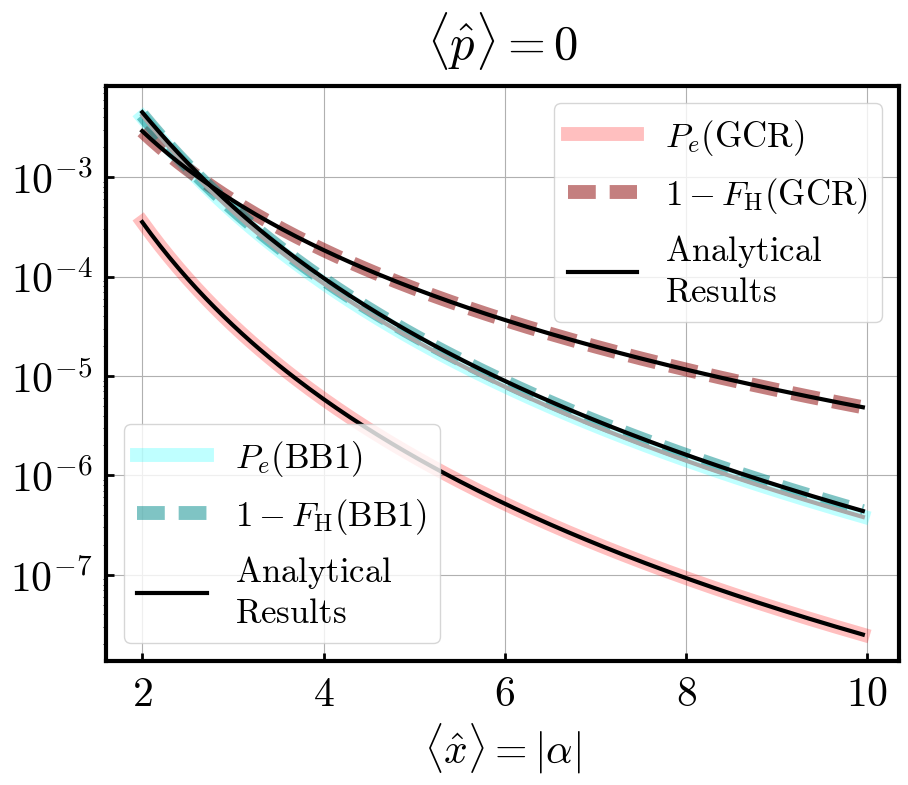

In [36]:
#Ncav=400
fail_b=np.load("Paper_Data/fail_b.npz")["arr_0"]
alph_b=np.load("Paper_Data/alph_b.npz")["arr_0"]
chi_b=np.load("Paper_Data/chi_b.npz")["arr_0"]
chi1=np.load("Paper_Data/chi1.npz")["arr_0"]
reset_fid=np.load("Paper_Data/reset_fid.npz")["arr_0"]
reset_b=np.load("Paper_Data/reset_b.npz")["arr_0"]
succ_b=np.load("Paper_Data/succ_b.npz")["arr_0"]
alph=np.load("Paper_Data/alph.npz")["arr_0"]
fail_prob=np.load("Paper_Data/fail_prob.npz")["arr_0"]
succ_fid=np.load("Paper_Data/succ_fid.npz")["arr_0"]
fig,ax=plt.subplots(1,1,figsize=(10,8))
def suc_bb1(chi):
    return 1.6*pow(chi,6)-3*pow(chi,8) #for BB1(90) 1.84*pow(chi,6)-9.68*pow(chi,8)
def res_bb1(chi):
    return 1.84*pow(chi,6)-4*pow(chi,8) #for BB1(90) 15.6*pow(chi,6)-0.034*pow(chi,8)
def suc_p(chi):
    return (5*pow(chi,6)/48-5*pow(chi,8)/96)/(1-29*pow(chi,8)/768)
def suc_f(chi):
    return (pow(chi,4)/8-pow(chi,6)/8+pow(chi,8)/64)/(1-5*pow(chi,6)/48+11*pow(chi,8)/768)#0.04chi^8
def res_f(chi):
    return (pow(chi,4)/8-pow(chi,6)/48)
succp=[suc_p(i) for i in chi1]
succb=[suc_bb1(i) for i in chi_b]
resb=[res_bb1(i) for i in chi_b]
succf=[suc_f(i) for i in chi1]
resetf=[res_f(i) for i in chi1]
gcr_1,=ax.plot(alph,fail_prob,"-",color="red",linewidth=10,alpha=0.25,label=r"$P_e(\mathrm{GCR})$")
bb_1,=ax.plot(alph_b,fail_b,"-",color="cyan",linewidth=10,alpha=0.25,label=r"$P_e(\mathrm{BB1})$")
#ax.plot(alph,succ_fid,color="blue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{GCR,s}$")
#ax.plot(alph_b,succ_b,"--",color="darkblue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{BB1,s}$")
gcr_2,=ax.plot(alph,reset_fid,"--",color="darkred",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-F_\mathrm{H}(\mathrm{GCR})$")
bb_2,=ax.plot(alph_b,reset_b,"--",color="darkcyan",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-F_\mathrm{H}(\mathrm{BB1})$")
ax.plot(alph_b,succb,'-',linewidth=3,alpha=1,color="darkgray")
bb_3,=ax.plot(alph_b,resb,'-',linewidth=3,alpha=1,color="black",label=r"$\mathrm{Analytical}$"+"\n"+"$\mathrm{Results}$")
gcr_3,=ax.plot(alph,succp,'-',linewidth=3,alpha=1,color="black",label=r"$\mathrm{Analytical}$"+"\n"+"$\mathrm{Results}$")
#ax.plot(alph,succf,'-',linewidth=1,alpha=1,color="black")
ax.plot(alph,resetf,'-',linewidth=3,alpha=1,color="black")
ax.set_yscale('log')
first_legend = ax.legend(handles=[gcr_1,gcr_2,gcr_3], loc='upper right',fontsize = 25)
second_legend = plt.legend(handles=[bb_1,bb_2,bb_3], loc='lower left',fontsize = 25)
ax.add_artist(first_legend)
ax.set_xlabel(r'$\langle\hat x\rangle=|\alpha|$',fontsize=30,font=font)
ax.set_yticks([0.001,0.0001,0.00001,0.000001,0.0000001],[r"$10^{-3}$",r"$10^{-4}$",r"$10^{-5}$",r"$10^{-6}$",r"$10^{-7}$"],font=font,fontsize=30)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
ax.set_xticks([2,4,6,8,10],[r"$2$",r"$4$",r"$6$",r"$8$",r"$10$"],fontsize=30)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
plt.grid()
fig.tight_layout(pad=4) 
plt.title(r"$\langle\hat p\rangle=0$",fontsize=35,pad=20)
plt.savefig('Paper_Figures/Error_Analysis.pdf',bbox_inches='tight',dpi=300,transparent=True)


### $2\theta=\pi$

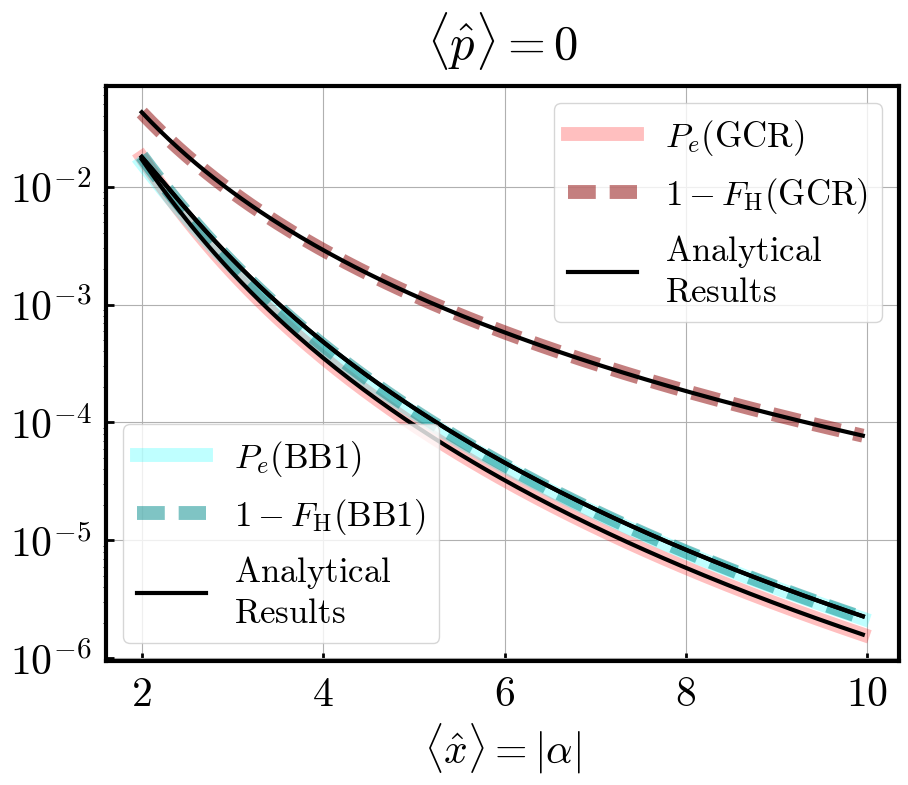

In [37]:
fail_b=np.load("Paper_Data/fail_b_pi.npz")["arr_0"]
alph_b=np.load("Paper_Data/alph_b_pi.npz")["arr_0"]
chi_b=np.load("Paper_Data/chi_b_pi.npz")["arr_0"]
chi1=np.load("Paper_Data/chi1_pi.npz")["arr_0"]
reset_fid=np.load("Paper_Data/reset_fid_pi.npz")["arr_0"]
reset_b=np.load("Paper_Data/reset_b_pi.npz")["arr_0"]
succ_b=np.load("Paper_Data/succ_b_pi.npz")["arr_0"]
alph=np.load("Paper_Data/alph_pi.npz")["arr_0"]
fail_prob=np.load("Paper_Data/fail_prob_pi.npz")["arr_0"]
succ_fid=np.load("Paper_Data/succ_fid_pi.npz")["arr_0"]
fig,ax=plt.subplots(1,1,figsize=(10,8))
def suc_bb1(chi):
    return 0.15*pow(chi,6)-0.12*pow(chi,8)#for BB1(180): 0.15*pow(chi,6)-0.32*pow(chi,8)
def res_bb1(chi):
    return 0.15*pow(chi,6)-0.12*pow(chi,8)#for BB1(180): 0.36*pow(chi,6)-0.008*pow(chi,8)
def suc_p(chi):
    return (5*pow(chi,6)/48-5*pow(chi,8)/96)/(1-29*pow(chi,8)/768)
def suc_f(chi):
    return (pow(chi,4)/8-pow(chi,6)/8+pow(chi,8)/64)/(1-5*pow(chi,6)/48+11*pow(chi,8)/768)#0.04chi^8
def res_f(chi):
    return (pow(chi,4)/8-pow(chi,6)/48)
succp=[suc_p(i) for i in chi1]
succb=[suc_bb1(i) for i in chi_b]
resb=[res_bb1(i) for i in chi_b]
succf=[suc_f(i) for i in chi1]
resetf=[res_f(i) for i in chi1]
gcr_1,=ax.plot(alph,fail_prob,"-",color="red",linewidth=10,alpha=0.25,label=r"$P_e(\mathrm{GCR})$")
bb_1,=ax.plot(alph_b,fail_b,"-",color="cyan",linewidth=10,alpha=0.25,label=r"$P_e(\mathrm{BB1})$")
#ax.plot(alph,succ_fid,color="blue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{GCR,s}$")
#ax.plot(alph_b,succ_b,"--",color="darkblue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{BB1,s}$")
gcr_2,=ax.plot(alph,reset_fid,"--",color="darkred",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-F_\mathrm{H}(\mathrm{GCR})$")
bb_2,=ax.plot(alph_b,reset_b,"--",color="darkcyan",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-F_\mathrm{H}(\mathrm{BB1})$")
ax.plot(alph_b,succb,'-',linewidth=3,alpha=1,color="black")
bb_3,=ax.plot(alph_b,resb,'-',linewidth=3,alpha=1,color="black",label=r"$\mathrm{Analytical}$"+"\n"+"$\mathrm{Results}$")
gcr_3,=ax.plot(alph,succp,'-',linewidth=3,alpha=1,color="black",label=r"$\mathrm{Analytical}$"+"\n"+"$\mathrm{Results}$")
#ax.plot(alph,succf,'-',linewidth=1,alpha=1,color="black")
ax.plot(alph,resetf,'-',linewidth=3,alpha=1,color="black")
ax.set_yscale('log')
first_legend = ax.legend(handles=[gcr_1,gcr_2,gcr_3], loc='upper right',fontsize = 25)
second_legend = plt.legend(handles=[bb_1,bb_2,bb_3], loc='lower left',fontsize = 25)
ax.add_artist(first_legend)
ax.set_xlabel(r'$\langle\hat x\rangle=|\alpha|$',fontsize=30,font=font)
ax.set_yticks([0.01,0.001,0.0001,0.00001,0.000001],[r"$10^{-2}$",r"$10^{-3}$",r"$10^{-4}$",r"$10^{-5}$",r"$10^{-6}$"],font=font,fontsize=30)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
ax.set_xticks([2,4,6,8,10],[r"$2$",r"$4$",r"$6$",r"$8$",r"$10$"],fontsize=30)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
plt.grid()
fig.tight_layout(pad=4) 
plt.title(r"$\langle\hat p\rangle=0$",fontsize=35,pad=20)
plt.savefig('Supp_Figures/Error_Analysis_pi.pdf',bbox_inches='tight',dpi=300,transparent=True)


### $p\neq0$

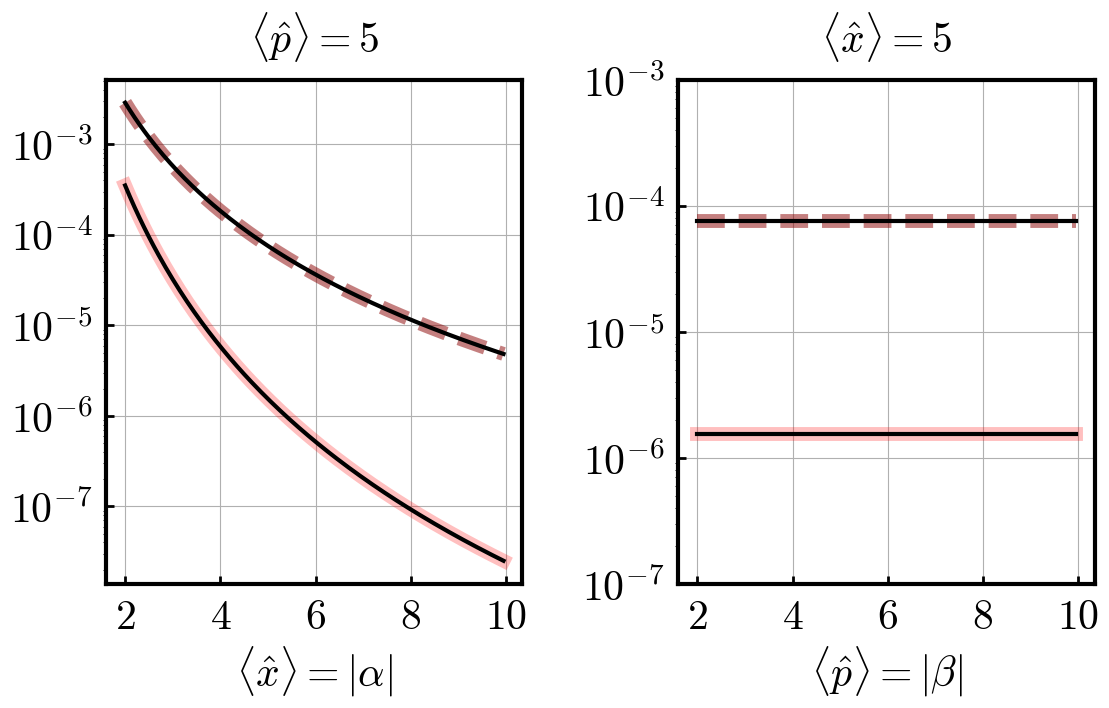

In [38]:
chi1=np.load("Paper_Data/chi1_p.npz")["arr_0"]
reset_fid=np.load("Paper_Data/reset_fid_p.npz")["arr_0"]
alph=np.load("Paper_Data/alph_p.npz")["arr_0"]
fail_prob=np.load("Paper_Data/fail_prob_p.npz")["arr_0"]
succ_fid=np.load("Paper_Data/succ_fid_p.npz")["arr_0"]
reset_fid1=np.load("Paper_Data/reset_fid_pa.npz")["arr_0"]
fail_prob1=np.load("Paper_Data/fail_prob_pa.npz")["arr_0"]
succ_fid1=np.load("Paper_Data/succ_fid_pa.npz")["arr_0"]
fig,ax=plt.subplots(1,2,figsize=(12,8))
def suc_p(chi):
    return (5*pow(chi,6)/48-5*pow(chi,8)/96)/(1-29*pow(chi,8)/768)
def suc_f(chi):
    return (pow(chi,4)/8-pow(chi,6)/8+pow(chi,8)/64)/(1-5*pow(chi,6)/48+11*pow(chi,8)/768)#0.04chi^8
def res_f(chi):
    return (pow(chi,4)/8-pow(chi,6)/48)
succp=[suc_p(i) for i in chi1]
succf=[suc_f(i) for i in chi1]
resetf=[res_f(i) for i in chi1]
ax[0].plot(alph,fail_prob,"-",color="red",linewidth=10,alpha=0.25,label=r"$\mathcal{P}_\mathrm{GCR}(\mathrm{fail})$")
#ax.plot(alph,succ_fid,color="blue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{GCR,s}$")
ax[0].plot(alph,reset_fid,"--",color="darkred",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-\mathcal{F}_\mathrm{GCR}$")
ax[0].plot(alph,succp,'-',linewidth=3,alpha=1,color="black",label=r"$\mathrm{Analytical}$"+"\n"+"$\mathrm{Results}$")
#ax.plot(alph,succf,'-',linewidth=1,alpha=1,color="black")
ax[0].plot(alph,resetf,'-',linewidth=3,alpha=1,color="black")
ax[0].set_yscale('log')

ax[1].plot(alph,fail_prob1,"-",color="red",linewidth=10,alpha=0.25,label=r"$\mathcal{P}_\mathrm{GCR}(\mathrm{fail})$")
#ax.plot(alph,succ_fid,color="blue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{GCR,s}$")
ax[1].plot(alph,reset_fid1,"--",color="darkred",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-\mathcal{F}_\mathrm{GCR}$")
ax[1].plot(alph,[suc_p(np.pi/4/5)]*len(alph),'-',linewidth=3,alpha=1,color="black",label=r"$\mathrm{Analytical}$"+"\n"+"$\mathrm{Results}$")
#ax.plot(alph,succf,'-',linewidth=1,alpha=1,color="black")
ax[1].plot(alph,[res_f(np.pi/4/5)]*len(alph),'-',linewidth=3,alpha=1,color="black")
ax[1].set_yscale('log')

ax[0].set_xlabel(r'$\langle\hat x\rangle=|\alpha|$',fontsize=30,font=font)
ax[0].set_title(r"$\langle\hat p\rangle=5$",fontsize=30,pad=20)
ax[1].set_xlabel(r'$\langle\hat p\rangle=|\beta|$',fontsize=30,font=font)
ax[1].set_title(r"$\langle\hat x\rangle=5$",fontsize=30,pad=20)
    
for i in range(2):
    ax[i].set_yticks([0.001,0.0001,0.00001,0.000001,0.0000001],[r"$10^{-3}$",r"$10^{-4}$",r"$10^{-5}$",r"$10^{-6}$",r"$10^{-7}$"],font=font,fontsize=30)
    ax[i].tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
    ax[i].set_xticks([2,4,6,8,10],[r"$2$",r"$4$",r"$6$",r"$8$",r"$10$"],fontsize=30)
    ax[i].tick_params(axis="x", direction='in', length=6, width=2,pad=10)
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(3)
ax[0].grid()
ax[1].grid()
fig.tight_layout(pad=4) 
plt.savefig('Paper_Figures/Error_Analysis_pnot0.pdf',bbox_inches='tight',dpi=300,transparent=True)


### Fig. 4 (Cat States)

In [39]:
eigenvals,eigenstat=xOp.eigenstates()
eigenvals1,eigenstat1=pOp.eigenstates()
axis_x=[]
psi1=[]
sx=[]
sy=[]
sz=[]
alpha=3#np.sqrt(np.pi)
delta=1
chi=-np.pi/4/alpha
Opx=tensor(1j*chi*xOp,sigmax()).expm()
Opy=tensor(1j*chi*pOp,sigmay()).expm()
State=ket2dm(((Opx*Opy*tensor((coherent(Ncav,alpha)+coherent(Ncav,-alpha)).unit(),g))).unit())#initial state
for i in range(len(eigenstat)):
    Op1=tensor(ket2dm(eigenstat[i]),qeye(2))
    new_State=Op1*State*Op1.dag()
    mod_Qubit=new_State.ptrace(1).unit()
    mod_State=new_State.ptrace(0).unit()
    axis_x.append(eigenvals[i])
    psi1.append(expect(ket2dm(eigenstat[i]),(State.ptrace(0))))
    sx.append(expect(sigmax(),mod_Qubit))
    sy.append(expect(sigmay(),mod_Qubit))
    sz.append(expect(sigmaz(),mod_Qubit))
c1=1/np.trapz(np.array(psi1),eigenvals)
psi1=c1*np.array(psi1)    


/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_5883/894155088.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c1=1/np.trapz(np.array(psi1),eigenvals)


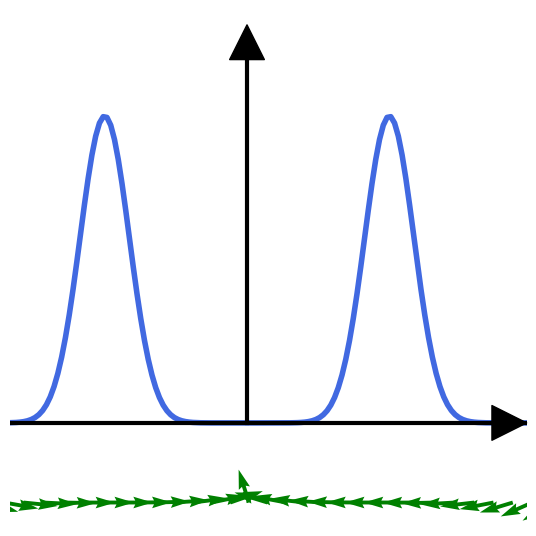

In [40]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(-alpha-2,alpha+2.9)
ax.axis("off")
ax.plot(axis_x,psi1,color="royalblue",linewidth=4,label=r"$|\psi(x)|^2$")
ax.plot(axis_x,[0]*len(axis_x),color="black",linewidth=3,label=r"$|\psi(x)|^2$")
ax.plot([0]*len(axis_x),np.linspace(0,0.49,len(axis_x)),color="black",linewidth=3,label=r"$|\psi(x)|^2$")
ax.annotate("",xy=(alpha+2.9, 0), xytext=(alpha+2.6, 0),arrowprops=dict(facecolor='black', headlength=25,headwidth=25,width=0.01),)
ax.annotate("",xy=(0,0.5), xytext=(0,0.4),arrowprops=dict(facecolor='black', headlength=25,headwidth=25,width=0.01),)
ax.quiver(np.real(axis_x[50:-50:5]),([-0.1]*(Ncav))[50:-50:5],np.real(sy[50:-50:5]),np.real(sz[50:-50:5]),scale=15,linewidth=1,color="green",label="xy-plane")
#ax.quiver(np.real(axis_x[-180:-140:10]),([-0.3]*(Ncav))[-180:-140:10],np.real(sy[-180:-140:10]),np.real(sz[-180:-140:10]),scale=15,linewidth=1,color="green",label="xy-plane")
fig.tight_layout(pad=3) 
plt.savefig('Paper_Figures/Prep_5.pdf',dpi=300,transparent=True)


10.0
0.0015397499790886782
4.2403410882574377e-07
2.4374064877541457e-08


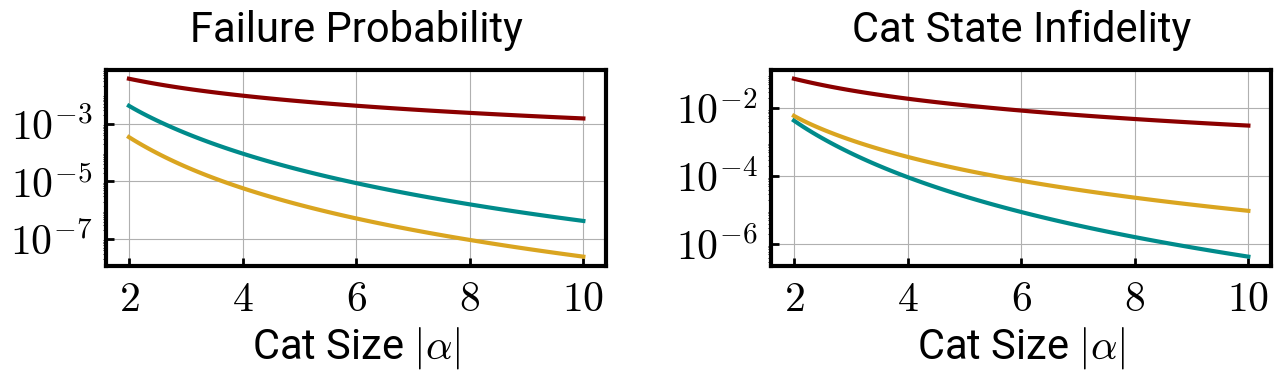

In [41]:
reset_fid=np.load("Paper_Data/reset_fid_cat.npz")["arr_0"]
alph=np.load("Paper_Data/alph_cat.npz")["arr_0"]
fail_prob=np.load("Paper_Data/fail_prob_cat.npz")["arr_0"]
succ_fid=np.load("Paper_Data/succ_fid_cat.npz")["arr_0"]
reset_fid1=np.load("Paper_Data/reset_fid_catb.npz")["arr_0"]
fail_prob1=np.load("Paper_Data/fail_prob_catb.npz")["arr_0"]
succ_fid1=np.load("Paper_Data/succ_fid_catb.npz")["arr_0"]
reset_fid2=np.load("Paper_Data/reset_fid_cat_I.npz")["arr_0"]
fail_prob2=np.load("Paper_Data/fail_prob_cat_I.npz")["arr_0"]
succ_fid2=np.load("Paper_Data/succ_fid_cat_I.npz")["arr_0"]
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].plot(alph,fail_prob,"-",color="darkred",linewidth=3,alpha=1)
ax[0].plot(alph,fail_prob1,"-",color="darkcyan",linewidth=3,alpha=1)
ax[0].plot(alph,fail_prob2,"-",color="goldenrod",linewidth=3,alpha=1)
ax[1].plot(alph,reset_fid,"-",color="darkred",linewidth=3,alpha=1)
ax[1].plot(alph,reset_fid1,"-",color="darkcyan",linewidth=3,alpha=1)
ax[1].plot(alph,reset_fid2,"-",color="goldenrod",linewidth=3,alpha=1)
ax[0].set_yscale('log')

ax[1].set_yscale('log')

ax[0].set_title("Failure Probability", font=font,fontsize=30,pad=20)
ax[1].set_title("Cat State Infidelity",font=font,fontsize=30,pad=20)

ax[0].set_yticks([0.001,0.00001,0.0000001],[r"$10^{-3}$",r"$10^{-5}$",r"$10^{-7}$"],font=font,fontsize=30)
ax[1].set_yticks([0.01,0.0001,0.000001],[r"$10^{-2}$",r"$10^{-4}$",r"$10^{-6}$"],font=font,fontsize=30)
    
for i in range(2):
    ax[i].set_xlabel(r"Cat Size $|\alpha|$",font=font,fontsize=30)
    ax[i].tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
    ax[i].set_xticks([2,4,6,8,10],[r"$2$",r"$4$",r"$6$",r"$8$",r"$10$"],fontsize=30)
    ax[i].tick_params(axis="x", direction='in', length=6, width=2,pad=10)
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(3)
    #ax[i].legend(fontsize=30)
ax[0].grid()
ax[1].grid()
fig.tight_layout(pad=5) 
plt.savefig('Paper_Figures/Error_Analysis_cat.pdf',bbox_inches='tight',dpi=300,transparent=True)
print(alph[-1])
print(fail_prob[-1])
print(fail_prob1[-1])
print(fail_prob2[-1])

### Fig. 3 (Squeezing)

/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_5883/365742360.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c1=1/np.trapz(np.array(psi1),eigenvals)
/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_5883/365742360.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c1=1/np.trapz(np.array(psi2),eigenvals)


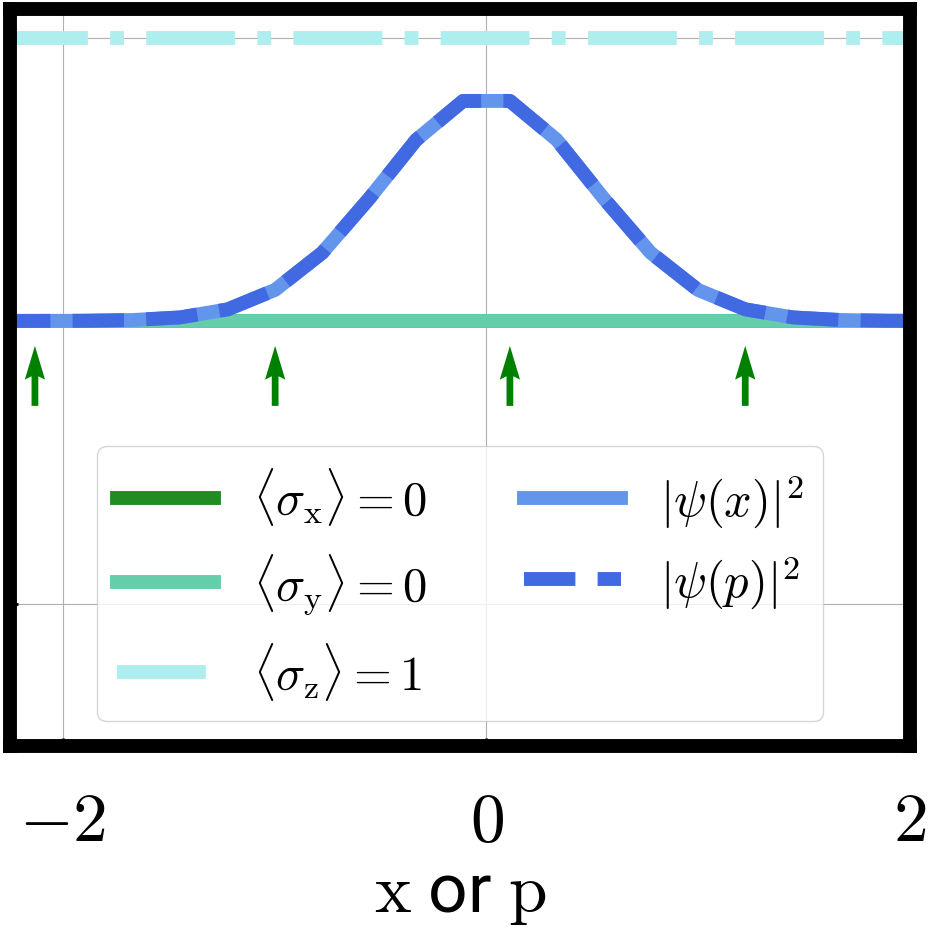

In [ ]:
#change Ncav to 50 before running this cell!
eigenvals,eigenstat=xOp.eigenstates()
eigenvals1,eigenstat1=pOp.eigenstates()
axis_x=[]
axis_p=[]
psi1=[]
psi2=[]
sx=[]
sy=[]
sz=[]
alpha=0.25
Opx=tensor(-2j*alpha*pOp,sigmax()).expm()
Opy=tensor(2j*alpha*xOp,sigmay()).expm()
State=ket2dm((tensor(basis(Ncav,0),g)).unit())#initial state
for i in range(len(eigenstat)):
    Op1=tensor(ket2dm(eigenstat[i]),qeye(2))
    new_State=Op1*State*Op1.dag()
    mod_Qubit=new_State.ptrace(1).unit()
    mod_State=new_State.ptrace(0).unit()
    axis_x.append(eigenvals[i])
    axis_p.append(eigenvals1[i])
    psi1.append(expect(ket2dm(eigenstat[i]),(State.ptrace(0))))
    psi2.append(expect(ket2dm(eigenstat1[i]),(State.ptrace(0))))
    sx.append(expect(sigmax(),mod_Qubit))
    sy.append(expect(sigmay(),mod_Qubit))
    sz.append(expect(sigmaz(),mod_Qubit))
c1=1/np.trapz(np.array(psi1),eigenvals)
psi1=c1*np.array(psi1)    
c1=1/np.trapz(np.array(psi2),eigenvals)
psi2=c1*np.array(psi2)    
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.set_xlim(alpha-2.5,alpha+1.5)
ax.annotate("",xy=(7.0, 0), xytext=(6.6, 0),arrowprops=dict(facecolor='black', headlength=25,headwidth=25,width=0.01),)
ax.annotate("",xy=(5,1.0), xytext=(5,0.9),arrowprops=dict(facecolor='black', headlength=25,headwidth=25,width=0.01),)
ax.plot(axis_x[:-10],[0]*(len(axis_x)-10),color="black",linewidth=3)
ax.plot([5]*len(axis_x),np.linspace(0,0.95,len(axis_x)),color="black",linewidth=3)
ax.quiver(np.real(axis_x[0:-1:5]),([-0.3]*(Ncav))[0:-1:5],np.real(sx[0:-1:5]),np.real(sz[0:-1:5]),scale=15,linewidth=10,color="green")
s_x,=ax.plot(axis_x,sx,"-o",color="forestgreen",linewidth=10,label=r"$\langle\sigma_\mathrm{x}\rangle=0$")
s_y,=ax.plot(axis_x,sy,"-x",color="mediumaquamarine",linewidth=10,label=r"$\langle\sigma_\mathrm{y}\rangle=0$")
s_z,=ax.plot(axis_x,sz,"-.",color="paleturquoise",linewidth=10,label=r"$\langle\sigma_\mathrm{z}\rangle=1$")
#ax.plot(axis_x,np.tanh(4*alpha*np.array(axis_x)))
#ax.plot(axis_x,1/np.cosh(4*alpha*np.array(axis_x)))
psi_1,=ax.plot(axis_x,psi1,"-",color="cornflowerblue",linewidth=10,label=r"$|\psi(x)|^2$")
psi_2,=ax.plot(axis_p,psi2,"--",color="royalblue",linewidth=10,label=r"$|\psi(p)|^2$")
#first_legend = ax.legend(handles=[psi_1,psi_2], loc='lower left',fontsize = 35,ncol=1)
#second_legend = plt.legend(handles=[s_x,s_y,s_z], loc='lower right',fontsize = 35,ncol=1)
#ax.add_artist(first_legend)
plt.legend(loc='lower center',fontsize = 35,ncol=2)
ax.set_ylim(-1.5,1.1)
ax.set_xlabel(r"$\mathrm{x}$ or $\mathrm{p}$",font=font,fontsize=50)
ax.set_yticks([1,0,-1],[r"",r"",r""],fontsize=50)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=30)
ax.set_xticks([-2,0,2],[r"$-2$",r"$0$",r"$2$"],fontsize=50)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=30)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(10)
ax.grid()
fig.tight_layout(pad=3) 
#plt.savefig('Paper_Figures/Squeeze.pdf',bbox_inches='tight',dpi=300,transparent=True)
#=\tanh{\frac{4\alpha x}{\Delta^2}}
#=1/\cosh{\frac{4\alpha x}{\Delta^2}}
#\sim \mathcal{O}(x^3)
#\sim 1

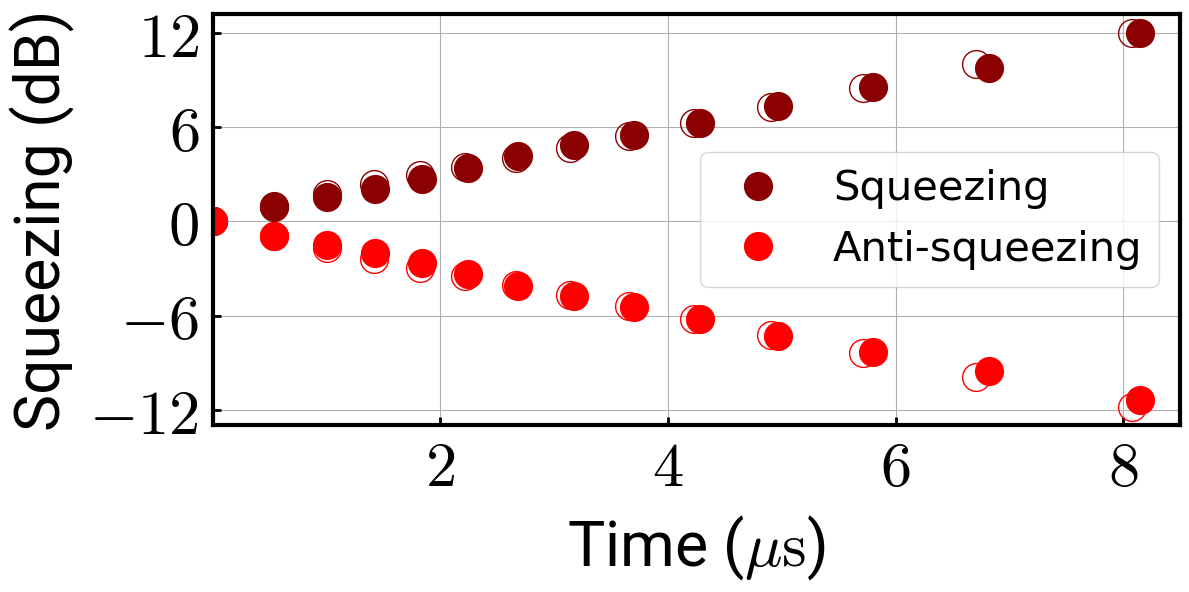

In [43]:
#my time is CD=time/sqrt(2) as it is extracted in the units where x=(a+a^\dagger)/sqrt(2). See NA-QSP_sims.ipynb
squeeze_x=np.load("Paper_Data/squeeze_x.npz")["arr_0"]
squeeze_p=np.load("Paper_Data/squeeze_p.npz")["arr_0"]
gate_count=np.load("Paper_Data/steps.npz")["arr_0"]
time=np.load("Paper_Data/time.npz")["arr_0"]
fisher=np.load("Paper_Data/fisher_info.npz")["arr_0"]
squeeze_x1=np.load("Paper_Data/squeeze_x_ps.npz")["arr_0"]
squeeze_p1=np.load("Paper_Data/squeeze_p_ps.npz")["arr_0"]
gate_count1=np.load("Paper_Data/steps_ps.npz")["arr_0"]
time1=np.load("Paper_Data/time_ps.npz")["arr_0"]
fisher1=np.load("Paper_Data/fisher_info_ps.npz")["arr_0"]
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(np.array(time)/np.sqrt(2),squeeze_p,"o",color="darkred",markersize=20,alpha=1,label="Squeezing")
ax.plot(np.array(time)/np.sqrt(2),squeeze_x,"o",color="red",alpha=1,markersize=20,label="Anti-squeezing")
ax.plot(np.array(time1)/np.sqrt(2),squeeze_p1,"o",markerfacecolor='none',color="darkred",markersize=20,alpha=1)
ax.plot(np.array(time1)/np.sqrt(2),squeeze_x1,"o",markerfacecolor='none',color="red",markersize=20,alpha=1)
#ax2 = ax.twiny()
#ax2.plot(gate_count,squeeze_p,"s",color="darkred",linewidth=3,alpha=1)
#ax2.plot(gate_count,squeeze_x,"s",color="darkcyan",linewidth=3,alpha=1)
ax.set_xlabel(r'Time ($\mu\mathrm{s}$)',font=font,fontsize=45,labelpad=10)
#ax2.set_xlabel('Gate Count',font=font,fontsize=40,labelpad=10)
ax.set_ylabel('Squeezing (dB)',font=font,fontsize=45,labelpad=10)
ax.set_yticks([-12,-6,0,6,12],[r"$-12$",r"$-6$",r"$0$",r"$6$",r"$12$"],font=font,fontsize=45)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
#ax2.set_xticks([0,4,8,12,14],[r"$0$",r"$4$",r"$8$" ,r"$12$" ,r"$14$"],fontsize=40)
ax.set_xticks([2,4,6,8],[r"$2$",r"$4$",r"$6$",r"$8$"],fontsize=45)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
#ax2.tick_params(axis="x", direction='in', length=6, width=2,pad=10)

#ax2.set_xlim(0,14.5)
ax.set_xlim(0,8.5)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
ax.legend(fontsize=30,loc="center right")

ax.grid()
fig.tight_layout() 
plt.savefig('Paper_Figures/Squeezing.pdf',bbox_inches='tight',dpi=300,transparent=True)


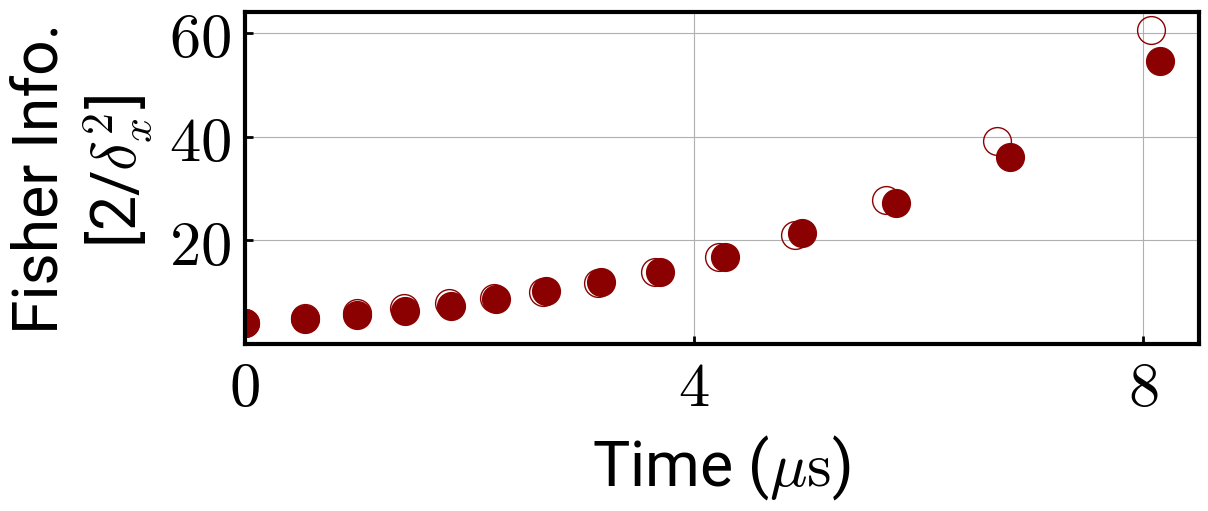

In [44]:
#my time is CD=time/sqrt(2)
gate_count=np.load("Paper_Data/steps.npz")["arr_0"]
time=np.load("Paper_Data/time.npz")["arr_0"]
fisher=np.load("Paper_Data/fisher_info.npz")["arr_0"]
fig, ax = plt.subplots(1,1,figsize=(13,6))
ax.plot(np.array(time)/np.sqrt(2),fisher,"o",color="darkred",markersize=20,alpha=1,label="Squeezing")
ax.plot(np.array(time1)/np.sqrt(2),fisher1,"o",markerfacecolor='none',color="darkred",markersize=20,alpha=1,label="Squeezing")
ax.set_xlabel(r'Time ($\mu\mathrm{s}$)',font=font,fontsize=45,labelpad=10)
ax.set_ylabel('Fisher Info.'+'\n'+r' [2/$\delta_x^2$]',font=font,fontsize=45,labelpad=10)
ax.set_yticks([20,40,60],[r"$20$",r"$40$",r"$60$"],font=font,fontsize=45)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
ax.set_xticks([0,4,8],[r"$0$",r"$4$",r"$8$"],fontsize=45)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
ax.set_ylim(0,64)
ax.set_xlim(0,8.5)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
ax.grid()
fig.tight_layout(pad=4) 
plt.savefig('Paper_Figures/Fisher.pdf',bbox_inches='tight',dpi=300,transparent=True)


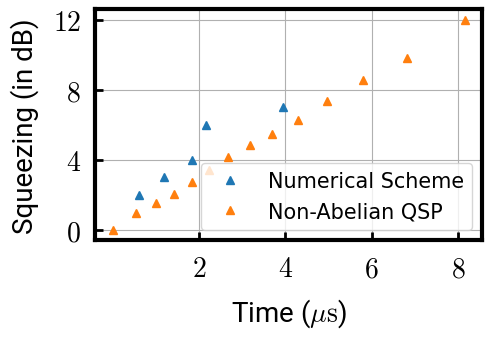

In [45]:
#alec's time is CD=time/2 while my time is CD=time/sqrt(2)
fig, ax = plt.subplots(1,1,figsize=(5,3))
AlecS=[2,3,4,6,7]
AlecN=[3,4,4,4,5]
AlecT=[1.2283807,2.390668,3.664669,4.309732,7.87374]#from GitHub repo of Alec et al.
ax.plot(np.array(AlecT)/2,np.array(AlecS),'^',label='Numerical Scheme')#should have an exponential increase
ax.plot(np.array(time)/np.sqrt(2),squeeze_p,'^',label='Non-Abelian QSP')#should have an exponential increase
ax.legend(fontsize=15,loc="lower right")
ax.set_ylabel('Squeezing (in dB)',fontsize=20,font=font,labelpad=10)
ax.set_xlabel(r'Time ($\mu\mathrm{s}$)',font=font,fontsize=20,labelpad=10)
ax.set_yticks([0,4,8,12],[r"$0$",r"$4$",r"$8$",r"$12$"],font=font,fontsize=20)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
ax.set_xticks([2,4,6,8],[r"$2$",r"$4$",r"$6$",r"$8$"],fontsize=20)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
ax.grid()
plt.savefig('Paper_Figures/num_squeezing.pdf',bbox_inches='tight',dpi=300,transparent=True)


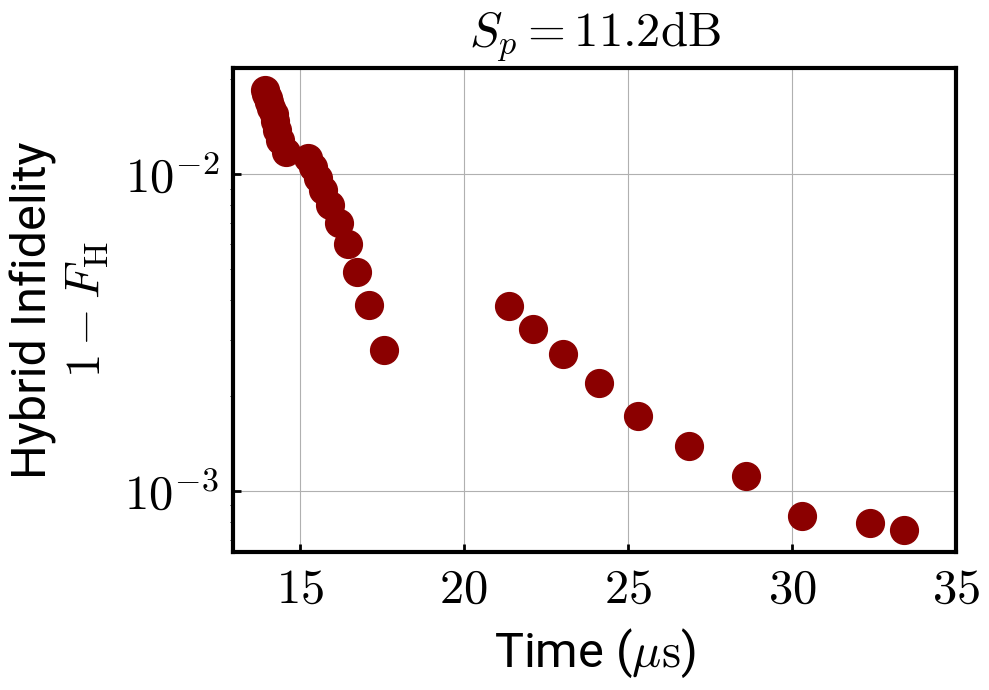

In [46]:
#here the time is same as CD=time (because it is extracted in the units of the paper)
#Fidelity v/s squeezing rate v/s circuit duration
squeeze_time=np.load("Paper_Data/squeeze_time.npz")["arr_0"]
squeeze_fidelity=np.load("Paper_Data/squeeze_fidelity.npz")["arr_0"]
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(squeeze_time,1-squeeze_fidelity,"o",color="darkred",markersize=20,alpha=1)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
ax.set_xlabel(r'Time ($\mu\mathrm{s}$)',font=font,fontsize=35,labelpad=10)
ax.set_ylabel("Hybrid Infidelity"+"\n"+r"$1-F_\mathrm{H}$",font=font,fontsize=35,labelpad=10)
ax.set_xticks([15,20,25,30,35],[r"$15$",r"$20$",r"$25$",r"$30$",r"$35$"],fontsize=35)
ax.set_yscale('log')#setting this after yticks will make yticks roboto
ax.set_yticks([10**(-2),10**(-3)],[r"$10^{-2}$",r"$10^{-3}$"],fontsize=35)
ax.set_title(r"$S_p=11.2\mathrm{dB}$",font=font,fontsize=35,pad=15)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
ax.grid()
fig.tight_layout() 
plt.savefig('Paper_Figures/Squeeze_Fidelity_time.pdf',bbox_inches='tight',dpi=300,transparent=True)


### Fig. 5 (GKP States)

[ 7.38926586  8.99212931 10.42021811 11.79004868 13.34215843 14.89426817
 16.44637792 17.99848767 19.55059741 21.10270716 22.65481691 24.20692665
 25.7590364  27.31114614 28.86325589 30.41536564 31.96747538 33.51958513
 35.07169487 36.62380462 38.17591437 39.72802411 41.28013386 42.8322436
 44.38435335 45.9364631  47.48857284 49.04068259 50.59279234 52.14490208
 53.69701183 55.24912157 56.80123132 58.35334107 59.90545081 61.45756056
 63.0096703  64.56178005 66.1138898  67.66599954 69.21810929 70.77021903
 72.32232878 73.87443853]


/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


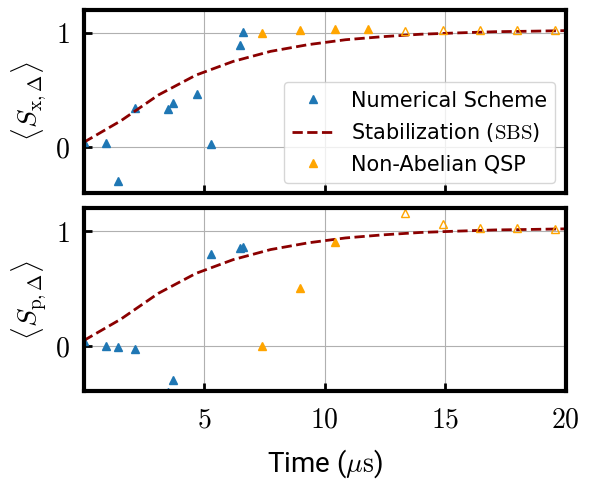

In [55]:
#my time is CD=time/2
#Sx and Sz figure
time_alec=np.array(np.load("Paper_Data/time_alec_400.npz")["arr_0"])
data_alec=np.load("Paper_Data/data_alec_400.npz")["arr_0"]
time_sbs=np.array(np.load("Paper_Data/time_sbs_400.npz")["arr_0"])
data_sbs=np.load("Paper_Data/data_sbs_400.npz")["arr_0"]
time_gcr=np.array(np.load("Paper_Data/time_gcr_400.npz")["arr_0"])
data_gcr=np.load("Paper_Data/data_gcr_400.npz")["arr_0"]
time_gcr=(time_gcr-10.45)/2+10.45/np.sqrt(2)#correcting the squeezing from CD*sqrt(2)=x units and the rest from CD*2=x units. 
print(time_gcr)
fig, ax = plt.subplots(2,1,figsize=(6,5),sharex=True)
plt.subplots_adjust(hspace=-0.5)
ax[0].plot(time_alec/2,np.real(data_alec[0]),"^",linewidth=3,alpha=1,label="Numerical Scheme")
ax[0].plot(time_sbs/2,np.real(data_sbs[0]),"--",color="darkred",linewidth=2,alpha=1,label=r"Stabilization ($\mathrm{SBS}$)")
ax[0].plot(time_gcr[:4],np.real(data_gcr[0][:4]),"^",color="orange",linewidth=3,alpha=1,label="Non-Abelian QSP")
ax[0].plot(time_gcr[4:],np.real(data_gcr[0][4:]),"^",color="orange",linewidth=3,markerfacecolor="none",alpha=1)
ax[1].plot(time_alec/2,np.real(data_alec[1]),"^",linewidth=3,alpha=1,label="Numerical Scheme")
ax[1].plot(time_sbs/2,np.real(data_sbs[1]),"--",color="darkred",linewidth=2,alpha=1,label="Stabilization")
ax[1].plot(time_gcr[:4],np.real(data_gcr[1][:4]),"^",color="orange",linewidth=3,alpha=1,label="Non-Abelian QSP")
ax[1].plot(time_gcr[4:],np.real(data_gcr[1][4:]),"^",color="orange",linewidth=3,markerfacecolor="none",alpha=1)
ax[1].set_xlabel(r'Time ($\mu\mathrm{s}$)',font=font,fontsize=20,labelpad=10)
ax[0].legend(fontsize=15,loc="lower right")
for i in range(2):
    ax[i].set_yticks([0,1],[r"$0$",r"$1$"],font=font,fontsize=20)
    ax[i].tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
    ax[i].tick_params(axis="x", direction='in', length=6, width=2,pad=10)
    ax[i].set_xlim(0,20)
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(3)
    ax[i].grid()
    ax[i].set_ylim(-0.4,1.2)
ax[1].set_xticks([5,10,15,20],[r"$5$",r"$10$",r"$15$",r"$20$"],fontsize=20)
ax[0].set_ylabel(r"$\langle S_\mathrm{x,\Delta}\rangle$",fontsize=20)
ax[1].set_ylabel(r"$\langle S_\mathrm{p,\Delta}\rangle$",fontsize=20)
fig.tight_layout() 
#plt.savefig('Paper_Figures/GKP_compare.pdf',bbox_inches='tight',dpi=300,transparent=True)


/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_1453/1111332699.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(fontsize=25,loc="lower right")


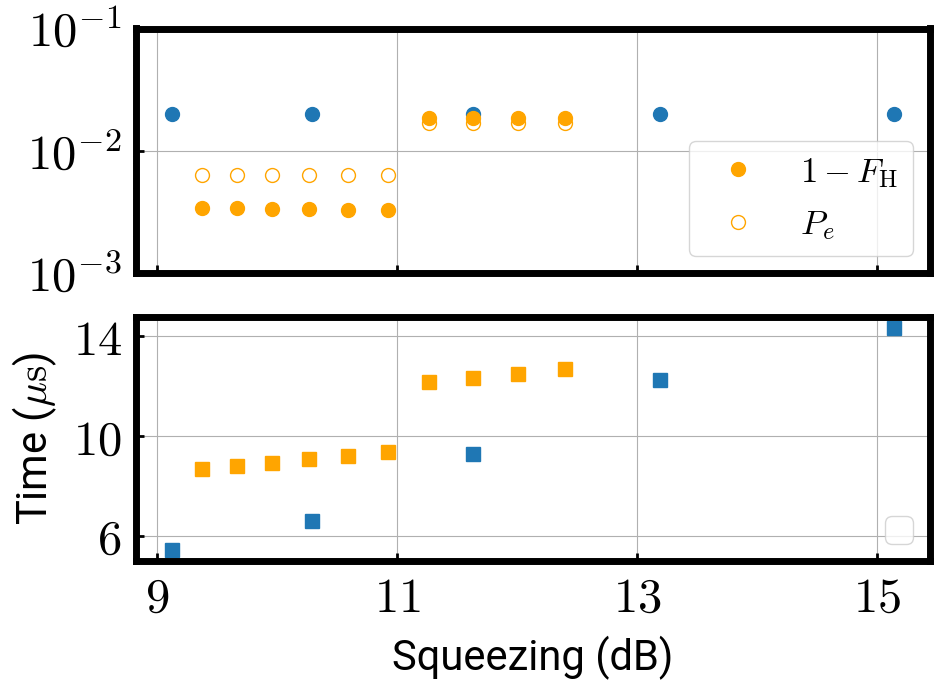

In [328]:
#here the time is same as CD=time
#Fidelity v/s squeezing rate v/s circuit duration
GKP_squeeze=np.load("Paper_Data/GKP_squeeze.npz")["arr_0"]
GKP_success=np.load("Paper_Data/GKP_success.npz")["arr_0"]
GKP_hyb_fidelity=np.load("Paper_Data/GKP_hyb_fidelity.npz")["arr_0"]
GKP_time=np.load("Paper_Data/GKP_time.npz")["arr_0"]
GKP_a_squeeze=np.load("Paper_Data/GKP_a_squeeze.npz")["arr_0"]
GKP_a_time=np.load("Paper_Data/GKP_a_time.npz")["arr_0"]
fig, ax = plt.subplots(2,1,figsize=(9.5,7))
ax[1].plot(GKP_squeeze,np.array(GKP_time)/2,"s",color="orange",markersize=10,alpha=1)
ax[1].plot(GKP_a_squeeze,np.array(GKP_a_time)/2,"s",markersize=10,alpha=1)
ax[0].plot(GKP_a_squeeze,1-np.array([0.98]*len(GKP_a_squeeze)),"o",markersize=10,alpha=1)
ax[0].plot(GKP_squeeze,1-np.array(GKP_hyb_fidelity),"o",color="orange",markersize=10,alpha=1,label=r"$1-F_\mathrm{H}$")
ax[0].plot(GKP_squeeze,1-np.array(GKP_success),"o",color="orange",markersize=10,markerfacecolor="none",alpha=1,label=r"$P_e$")
for i in range(2):
    ax[i].tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
    ax[i].tick_params(axis="x", direction='in', length=6, width=2,pad=10)
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(5)
    ax[i].grid()
ax[0].set_xticks([9,11,13,15],[r"",r"",r"",r""],fontsize=35)
ax[1].set_xticks([9,11,13,15],[r"$9$",r"$11$",r"$13$",r"$15$"],fontsize=35)
ax[1].legend(fontsize=25,loc="lower right")
ax[0].legend(fontsize=25,loc="lower right")

ax[1].set_xlabel("Squeezing (dB)",font=font,fontsize=30,labelpad=10)
ax[1].set_ylabel(r'Time ($\mu\mathrm{s}$)',font=font,fontsize=30,labelpad=10)
ax[1].set_yticks([6,10,14],[r"$6$",r"$10$",r"$14$"],fontsize=35)
ax[0].set_yscale('log')
ax[0].set_yticks([10**(-1),10**(-2),10**(-3)],[r"$10^{-1}$",r"$10^{-2}$",r"$10^{-3}$"],fontsize=35)
fig.tight_layout() 
plt.savefig('Paper_Figures/GKP_Fidelity.pdf',bbox_inches='tight',dpi=300,transparent=True)


/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_44804/2258633493.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


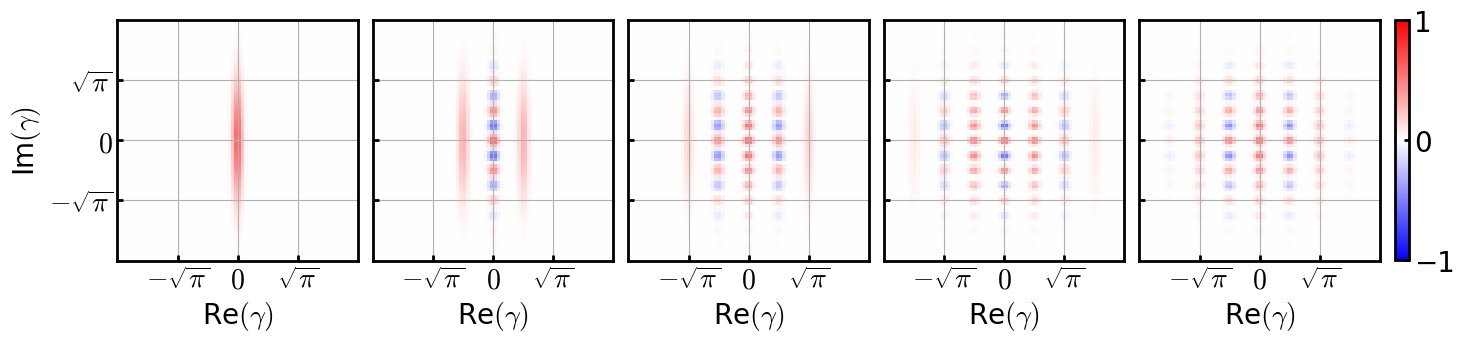

In [39]:
#Figures for circuit diagram: Wigner
state_gcr=np.load("Paper_Data/state_gcr_400.npz",allow_pickle=True)["arr_0"]
fig, ax = plt.subplots(1,5,figsize=(14,12),sharey=True)
#plt.subplots_adjust(hspace=0.01)
Gkp_arr=[-2*np.sqrt(np.pi)/2, 0.,2*np.sqrt(np.pi)/2]
Gkp_string=[r"$-\sqrt{\pi}$", r"$0$",r"$\sqrt{\pi}$"]


vmin = -1
vmax = 1
fontsize = 20
lim=7
extent1=5
xvec = np.linspace(-lim,lim,100)
ax[0].set_ylabel(r"Im$(\gamma)$", weight="medium", fontsize=fontsize)
    
for i in range(5):
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(2)
    ax[i].tick_params(axis="x", direction='in', length=4, width=2)
    ax[i].tick_params(axis="y", direction='in', length=4, width=2)
    ax[i].set_xticks(Gkp_arr,Gkp_string, fontsize=fontsize)
    ax[i].set_xlabel(r"Re$(\gamma)$", weight="medium", fontsize=fontsize)
    ax[i].set_yticks(Gkp_arr,Gkp_string, fontsize=fontsize)
    ax[i].set_xlim(-2*np.sqrt(np.pi),2*np.sqrt(np.pi))
    ax[i].set_ylim(-2*np.sqrt(np.pi),2*np.sqrt(np.pi))
    W = wigner(state_gcr[i],xvec,xvec,g=2)#Alec's wigner plot
    ax[i].imshow(W, origin='lower', extent=[-extent1,extent1,-extent1,extent1], cmap='bwr', vmin=vmin, vmax=vmax, rasterized=True) 
    ax[i].grid()

W = wigner(state_gcr[i],xvec,xvec,g=2)#Alec's wigner plot
p00 = ax[4].imshow(W, origin='lower', extent=[-extent1,extent1,-extent1,extent1], cmap='bwr', vmin=vmin, vmax=vmax, rasterized=True)    
cbaxes = fig.add_axes([1.0, 0.4, 0.01,0.2]) 
cbar   = plt.colorbar(p00, fraction=0.046, pad=0.04, cax=cbaxes)
#cbar   = plt.colorbar(p00, fraction=0.046, pad=0.04)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(direction='in', width=2, labelsize=fontsize)
cbar.outline.set_color('k')
cbar.outline.set_linewidth(2)
fig.tight_layout() 
#plt.savefig('Paper_Figures/GKP_wigner.pdf',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

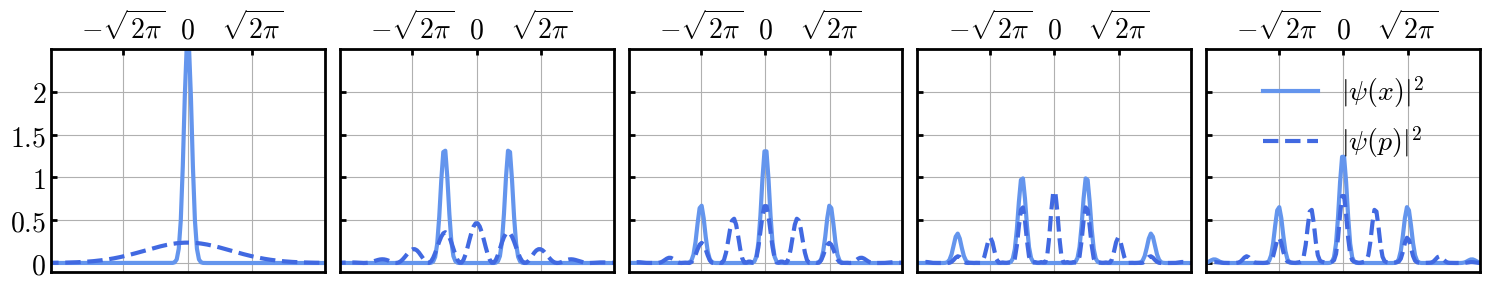

In [ ]:
#change Ncav to 400 here!
Gkp_arr=[-np.sqrt(2*np.pi), 0.,np.sqrt(2*np.pi)]
Gkp_string=[r"$-\sqrt{2\pi}$",r"$0$",r"$\sqrt{2\pi}$"]
eigenvals,eigenstat=xOp.eigenstates()
eigenvals1,eigenstat1=pOp.eigenstates()
axis_x=[]
axis_p=[]
psi1=[]
psi2=[]
psi3=[]
psi4=[]
psi5=[]
psi_1=[]
psi_2=[]
psi_3=[]
psi_4=[]
psi_5=[]
for i in range(len(eigenstat)):
    axis_x.append(eigenvals[i])
    axis_p.append(eigenvals1[i])
    psi1.append(expect(ket2dm(eigenstat[i]),(state_gcr[0])))
    psi2.append(expect(ket2dm(eigenstat[i]),(state_gcr[1])))
    psi3.append(expect(ket2dm(eigenstat[i]),(state_gcr[2])))
    psi4.append(expect(ket2dm(eigenstat[i]),(state_gcr[3])))
    psi5.append(expect(ket2dm(eigenstat[i]),(state_gcr[4])))
    psi_1.append(expect(ket2dm(eigenstat1[i]),(state_gcr[0])))
    psi_2.append(expect(ket2dm(eigenstat1[i]),(state_gcr[1])))
    psi_3.append(expect(ket2dm(eigenstat1[i]),(state_gcr[2])))
    psi_4.append(expect(ket2dm(eigenstat1[i]),(state_gcr[3])))
    psi_5.append(expect(ket2dm(eigenstat1[i]),(state_gcr[4])))
    
c1=1/np.trapz(np.array(psi1),eigenvals)
psi1=np.array(psi1)*c1 
c2=1/np.trapz(np.array(psi2),eigenvals1)
psi2=c2*np.array(psi2) 
c3=1/np.trapz(np.array(psi3),eigenvals)
psi3=c3*np.array(psi3) 
c4=1/np.trapz(np.array(psi4),eigenvals)
psi4=c4*np.array(psi4)   
c5=1/np.trapz(np.array(psi5),eigenvals)
psi5=c4*np.array(psi5)   
c1=1/np.trapz(np.array(psi_1),eigenvals)
psi_1=np.array(psi_1)*c1 
c2=1/np.trapz(np.array(psi_2),eigenvals1)
psi_2=c2*np.array(psi_2) 
c3=1/np.trapz(np.array(psi_3),eigenvals)
psi_3=c3*np.array(psi_3) 
c4=1/np.trapz(np.array(psi_4),eigenvals)
psi_4=c4*np.array(psi_4)   
c5=1/np.trapz(np.array(psi_5),eigenvals)
psi_5=c4*np.array(psi_5)   
fig, ax = plt.subplots(1,5,figsize=(15,3),sharey=True)

ax[0].plot(axis_x,psi1,color="cornflowerblue",linewidth=3)#gives expectation of sigmaz
ax[1].plot(axis_x,psi2,color="cornflowerblue",linewidth=3)#gives expectation of sigmaz
ax[2].plot(axis_x,psi3,color="cornflowerblue",linewidth=3)#gives expectation of sigmaz
ax[3].plot(axis_x,psi4,color="cornflowerblue",linewidth=3)#gives expectation of sigmaz
ax[4].plot(axis_x,psi5,color="cornflowerblue",linewidth=3,label=r"$|\psi(x)|^2$")#gives expectation of sigmaz

ax[0].plot(axis_p,psi_1,"--",color="royalblue",linewidth=3)#gives expectation of sigmaz
ax[1].plot(axis_p,psi_2,"--",color="royalblue",linewidth=3)#gives expectation of sigmaz
ax[2].plot(axis_p,psi_3,"--",color="royalblue",linewidth=3)#gives expectation of sigmaz
ax[3].plot(axis_p,psi_4,"--",color="royalblue",linewidth=3)#gives expectation of sigmaz
ax[4].plot(axis_p,psi_5,"--",color="royalblue",linewidth=3,label=r"$|\psi(p)|^2$")#gives expectation of sigmaz
for i in range(5):
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(2)
    ax[i].xaxis.tick_top()
    ax[i].tick_params(axis="x", direction='in', length=4, width=2)
    ax[i].tick_params(axis="y", direction='in', length=4, width=2)
    ax[i].set_xticks(Gkp_arr,Gkp_string, fontsize=fontsize)
    #ax[i].set_xlabel(r"Re$(\alpha)$", weight="medium", fontsize=fontsize)
    ax[i].set_yticks([0,0.5,1,1.5,2],[r"$0$",r"$0.5$",r"$1$",r"$1.5$",r"$2$"], fontsize=fontsize)
    ax[i].set_xlim(-2*np.sqrt(np.pi),2*np.sqrt(np.pi))
    ax[i].set_ylim(0,1.5)
    ax[i].grid()
    ax[i].set_xlim(-3*np.sqrt(np.pi),3*np.sqrt(np.pi))
ax[4].legend(loc='upper center',prop={'size': 20},frameon=False)
plt.ylim(-0.1,2.5)
fig.tight_layout() 
#plt.savefig('Paper_Figures/GKP_wavef.pdf',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


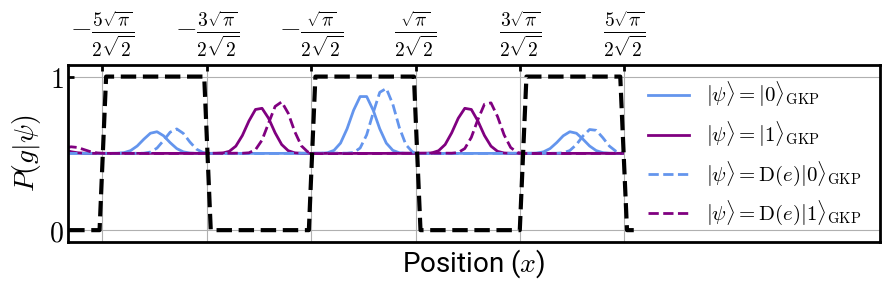

In [ ]:
#change Ncav to 400 here too!

from scipy import signal
Gkp_arr=[-5*np.sqrt(np.pi/2)/2,-3*np.sqrt(np.pi/2)/2,-np.sqrt(np.pi/2)/2, np.sqrt(np.pi/2)/2,3*np.sqrt(np.pi/2)/2,5*np.sqrt(np.pi/2)/2]
Gkp_string=[r"$-\frac{5\sqrt{\pi}}{2\sqrt{2}}$",r"$-\frac{3\sqrt{\pi}}{2\sqrt{2}}$",r"$-\frac{\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{3\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{5\sqrt{\pi}}{2\sqrt{2}}$"]
eigenvals,eigenstat=xOp.eigenstates()
eigenvals1,eigenstat1=pOp.eigenstates()
axis_x=[]
axis_p=[]
psi1=[]
psi_1=[]
psi2=[]
psi_2=[]
state_err0=(displace(Ncav,0.5)*state_gcr[-2]).unit()
state_err1=(displace(Ncav,0.5)*state_gcr[-1]).unit()
for i in range(len(eigenstat)):
    axis_x.append(eigenvals[i])
    axis_p.append(eigenvals1[i])
    psi1.append(expect(ket2dm(eigenstat[i]),(state_gcr[-2])))
    psi2.append(expect(ket2dm(eigenstat[i]),(state_gcr[-1])))
    psi_1.append(expect(ket2dm(eigenstat[i]),(state_err0)))
    psi_2.append(expect(ket2dm(eigenstat[i]),(state_err1)))
    
sq_wave=-2*signal.square(np.sqrt(2*np.pi)*(np.array(axis_x)))
cosine_wave=2*np.cos((np.array(axis_x)-np.sqrt(np.pi)-0.1)*2*np.sqrt(np.pi/2))
c1=1/np.trapz(np.array(psi1),eigenvals)
psi1=np.array(psi1)*c1 
c1=1/np.trapz(np.array(psi2),eigenvals)
psi2=np.array(psi2)*c1 
c1=1/np.trapz(np.array(psi_1),eigenvals)
psi_1=np.array(psi_1)*c1 
c1=1/np.trapz(np.array(psi_2),eigenvals)
psi_2=np.array(psi_2)*c1 

fig, ax = plt.subplots(1,1,figsize=(9,3),sharey=True)

ax.plot(axis_x[150:-160],psi1[150:-160],color="cornflowerblue",linewidth=2,label=r"$|\psi\rangle=|0\rangle_\mathrm{GKP}$")#gives expectation of sigmaz
ax.plot(axis_x[150:-160],psi2[150:-160],color="purple",linewidth=2,label=r"$|\psi\rangle=|1\rangle_\mathrm{GKP}$")#gives expectation of sigmaz

ax.plot(axis_x[150:-160],psi_1[150:-160],"--",color="cornflowerblue",linewidth=2,label=r"$|\psi\rangle=\mathrm{D}(\epsilon)|0\rangle_\mathrm{GKP}$")#gives expectation of sigmaz
ax.plot(axis_x[150:-160],psi_2[150:-160],"--",color="purple",linewidth=2,label=r"$|\psi\rangle=\mathrm{D}(\epsilon)|1\rangle_\mathrm{GKP}$")#gives expectation of sigmaz

ax.plot(axis_x[175:-135]-np.sqrt(np.pi)-0.1,sq_wave[175:-135],"--",color="black",linewidth=3)#gives expectation of sigmaz
#ax.plot(axis_x[175:-125]-np.sqrt(np.pi)-0.1,cosine_wave[175:-125],"--",color="orange",linewidth=3)#gives expectation of sigmaz

for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(2)
ax.xaxis.tick_top()
ax.tick_params(axis="x", direction='in', length=4, width=2)
ax.tick_params(axis="y", direction='in', length=4, width=2)
ax.set_xticks(Gkp_arr,Gkp_string, fontsize=fontsize)
ax.set_xlabel(r"Position ($x$)", weight="medium", fontsize=fontsize, font=font)
ax.set_ylabel(r"$P(g|\psi)$", weight="medium", fontsize=fontsize, font=font)
ax.set_yticks([2,-2],[r"$1$",r"$0$"], fontsize=fontsize)
ax.set_xlim(-2*np.sqrt(np.pi),2*np.sqrt(np.pi))
ax.grid()
ax.set_xlim(-2*np.sqrt(np.pi),3.5*np.sqrt(np.pi))
ax.legend(loc='center right',prop={'size': 15},frameon=False)
#ax.axis("off")
ax.set_ylim(-2.3,2.3)
fig.tight_layout() 
#plt.savefig('Paper_Figures/GKP_readout_wave.pdf',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

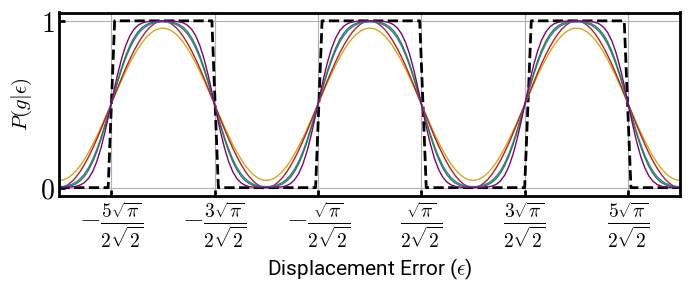

In [42]:
from scipy import signal
Gkp_arr=[-5*np.sqrt(np.pi/2)/2,-3*np.sqrt(np.pi/2)/2,-np.sqrt(np.pi/2)/2, np.sqrt(np.pi/2)/2,3*np.sqrt(np.pi/2)/2,5*np.sqrt(np.pi/2)/2]
Gkp_string=[r"$-\frac{5\sqrt{\pi}}{2\sqrt{2}}$",r"$-\frac{3\sqrt{\pi}}{2\sqrt{2}}$",r"$-\frac{\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{3\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{5\sqrt{\pi}}{2\sqrt{2}}$"]
    
sq_wave=(-signal.square(np.sqrt(2*np.pi)*(np.array(axis_x)))+1)/2
fig, ax = plt.subplots(1,1,figsize=(7,3),sharey=True)

ideal=np.load("Paper_Data/ideal_GKP.npz")["arr_0"]
bb1=np.load("Paper_Data/BB1_GKP.npz")["arr_0"]
finite_readout=np.load("Paper_Data/finite_GKP.npz")["arr_0"]
finite_bb1=np.load("Paper_Data/GCRBB1_GKP.npz")["arr_0"]
GCR_BB1=np.array(np.load("Paper_Data/GCR_BB1_GKP.npz")["arr_0"])
err_GCR_BB1=(np.array(np.load("Paper_Data/GCR_BB1_GKP_err.npz")["arr_0"]))+np.sqrt(np.pi/2)/2

ax.plot(axis_x-np.sqrt(np.pi)-0.1,sq_wave,"--",color="black",linewidth=2)#gives expectation of sigmaz
ax.plot(err_GCR_BB1,1-ideal,color="goldenrod",linewidth=1,label="Infinite GKP")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,1-finite_readout,color="firebrick",linewidth=1,label="GCR")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,bb1,color="royalblue",linewidth=1,label="BB1")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,1-finite_bb1,color="forestgreen",linewidth=1,label="GCR-BB1")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,GCR_BB1,color="purple",linewidth=1,label="BB1(GCR)")#gives expectation of sigmaz

for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(2)
#ax.xaxis.tick_top()
ax.tick_params(axis="x", direction='in', length=4, width=2)
ax.tick_params(axis="y", direction='in', length=4, width=2)
ax.set_xticks(Gkp_arr,Gkp_string, fontsize=fontsize)
ax.set_xlabel(r"Displacement Error ($\epsilon$)", weight="medium", fontsize=15,font=font)
ax.set_ylabel(r"$P(g|\epsilon)$", weight="medium", fontsize=15)
ax.set_yticks([1,0],[r"$1$",r"$0$"], fontsize=fontsize)
#ax.set_xlim(-2*np.sqrt(np.pi),2*np.sqrt(np.pi))
ax.grid()
ax.set_xlim(-3*np.sqrt(np.pi/2),3*np.sqrt(np.pi/2))
#ax.legend(loc='center right',prop={'size': 15},frameon=False)
#ax.set_ylim(-2.3,2.3)
fig.tight_layout() 
#plt.savefig('Paper_Figures/GKP_readout_graphs.pdf',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

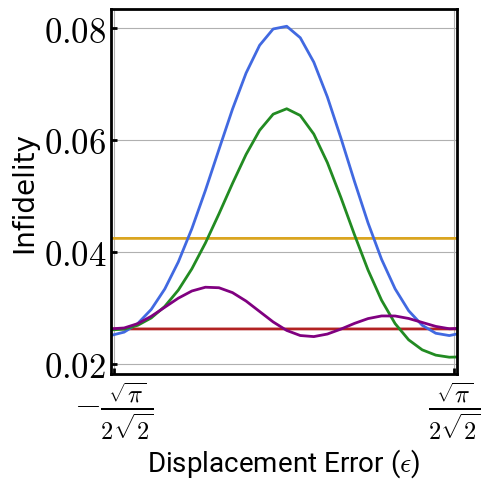

In [44]:
#fidelity curves
from scipy import signal
Gkp_arr=[-5*np.sqrt(np.pi/2)/2,-3*np.sqrt(np.pi/2)/2,-np.sqrt(np.pi/2)/2, np.sqrt(np.pi/2)/2,3*np.sqrt(np.pi/2)/2,5*np.sqrt(np.pi/2)/2]
Gkp_string=[r"$-\frac{5\sqrt{\pi}}{2\sqrt{2}}$",r"$-\frac{3\sqrt{\pi}}{2\sqrt{2}}$",r"$-\frac{\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{3\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{5\sqrt{\pi}}{2\sqrt{2}}$"]
    
sq_wave=(-signal.square(np.sqrt(2*np.pi)*(np.array(axis_x)))+1)/2
fig, ax = plt.subplots(1,1,figsize=(5,5),sharey=True)

fid_ideal=np.load("Paper_Data/ideal_GKP_fid.npz")["arr_0"]
fid_finite_readout=np.load("Paper_Data/finite_GKP_fid.npz")["arr_0"]
fid_bb1=np.array(np.load("Paper_Data/BB1_GKP_fid.npz")["arr_0"])
fid_finite_bb1=np.load("Paper_Data/GCRBB1_GKP_fid.npz")["arr_0"]
fid_GCR_BB1=np.array(np.load("Paper_Data/GCR_BB1_GKP_fid.npz")["arr_0"])
err_GCR_BB1=(np.array(np.load("Paper_Data/GCR_BB1_GKP_err.npz")["arr_0"]))

ax.plot(err_GCR_BB1,1-fid_ideal,color="goldenrod",linewidth=2,label="Infinite GKP")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,1-fid_finite_readout,color="firebrick",linewidth=2,label="GCR")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,1-fid_bb1,color="royalblue",linewidth=2,label="BB1")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,1-fid_finite_bb1,color="forestgreen",linewidth=2,label="GCR-BB1")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,1-fid_GCR_BB1,color="purple",linewidth=2,label="BB1(GCR)")#gives expectation of sigmaz

for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(2)
#ax.xaxis.tick_top()
ax.tick_params(axis="x", direction='in', length=4, width=2)
ax.tick_params(axis="y", direction='in', length=4, width=2)
ax.set_xticks(Gkp_arr,Gkp_string, fontsize=fontsize)
ax.set_xlabel(r"Displacement Error ($\epsilon$)", weight="medium", fontsize=20,font=font)
ax.set_ylabel(r"Infidelity", weight="medium", fontsize=20)
ax.set_xticks([-np.sqrt(np.pi/2)/2,np.sqrt(np.pi/2)/2],[r"$-\frac{\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{\sqrt{\pi}}{2\sqrt{2}}$"], fontsize=25)
#ax.set_yticks([0.001,0.01,0.1,1],[r"$10^{-3}$",r"$10^{-2}$",r"$10^{-1}$",r"$1$"], fontsize=fontsize)
ax.grid()
ax.set_xlim(-np.sqrt(np.pi/2)/2-0.01,np.sqrt(np.pi/2)/2+0.01)
ax.set_yticks([0.02,0.04,0.06,0.08],[r"$0.02$",r"$0.04$",r"$0.06$",r"$0.08$"], fontsize=25)
#ax.grid()
fig.tight_layout() 
#plt.savefig('Paper_Figures/GKP_readout_fidelity.pdf',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

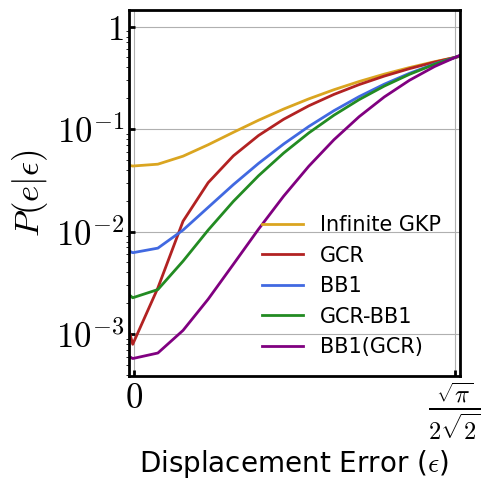

In [ ]:
#Zoomed
from scipy import signal
Gkp_arr=[-5*np.sqrt(np.pi/2)/2,-3*np.sqrt(np.pi/2)/2,-np.sqrt(np.pi/2)/2, 0.01,np.sqrt(np.pi/2)/2,3*np.sqrt(np.pi/2)/2,5*np.sqrt(np.pi/2)/2]
Gkp_string=[r"$-\frac{5\sqrt{\pi}}{2\sqrt{2}}$",r"$-\frac{3\sqrt{\pi}}{2\sqrt{2}}$",r"$-\frac{\sqrt{\pi}}{2\sqrt{2}}$","$0$",r"$\frac{\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{3\sqrt{\pi}}{2\sqrt{2}}$",r"$\frac{5\sqrt{\pi}}{2\sqrt{2}}$"]
    
sq_wave=(-signal.square(np.sqrt(2*np.pi)*(np.array(axis_x)))+1)/2
fig, ax = plt.subplots(1,1,figsize=(5,5),sharey=True)
fontsize=25
ideal=np.load("Paper_Data/ideal_GKP.npz")["arr_0"]
bb1=np.load("Paper_Data/BB1_GKP.npz")["arr_0"]
finite_readout=np.load("Paper_Data/finite_GKP.npz")["arr_0"]
finite_bb1=np.load("Paper_Data/GCRBB1_GKP.npz")["arr_0"]
GCR_BB1=np.array(np.load("Paper_Data/GCR_BB1_GKP.npz")["arr_0"])
err_GCR_BB1=(np.array(np.load("Paper_Data/GCR_BB1_GKP_err.npz")["arr_0"]))+np.sqrt(np.pi/2)/2

#ax.plot(axis_x-np.sqrt(np.pi)-0.1,sq_wave,"--",color="black",linewidth=2)#gives expectation of sigmaz
ax.plot(err_GCR_BB1,ideal,color="goldenrod",linewidth=2,label="Infinite GKP")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,finite_readout,color="firebrick",linewidth=2,label="GCR")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,1-bb1,color="royalblue",linewidth=2,label="BB1")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,finite_bb1,color="forestgreen",linewidth=2,label="GCR-BB1")#gives expectation of sigmaz
ax.plot(err_GCR_BB1,1-GCR_BB1,color="purple",linewidth=2,label="BB1(GCR)")#gives expectation of sigmaz

for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(2)
#ax.xaxis.tick_top()
ax.tick_params(axis="x", direction='in', length=4, width=2)
ax.tick_params(axis="y", direction='in', length=4, width=2)
ax.set_xticks(Gkp_arr,Gkp_string, fontsize=fontsize)
ax.set_xlabel(r"Displacement Error ($\epsilon$)", weight="medium", fontsize=20)
ax.set_ylabel(r"$P(e|\epsilon)$", weight="medium", fontsize=fontsize)
ax.set_yscale('log')
ax.set_xticks([-0.01,np.sqrt(np.pi/2)/2],[r"$0$",r"$\frac{\sqrt{\pi}}{2\sqrt{2}}$"], fontsize=fontsize)
ax.set_yticks([0.001,0.01,0.1,1],[r"$10^{-3}$",r"$10^{-2}$",r"$10^{-1}$",r"$1$"], fontsize=fontsize)
ax.grid()
ax.set_xlim(-0.02,np.sqrt(np.pi/2)/2+0.01)
ax.legend(loc='lower right',prop={'size': 15},frameon=False)
fig.tight_layout() 
#plt.savefig('Paper_Figures/GKP_readout_graphs_zoomed.pdf',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

### GKP Gates

/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


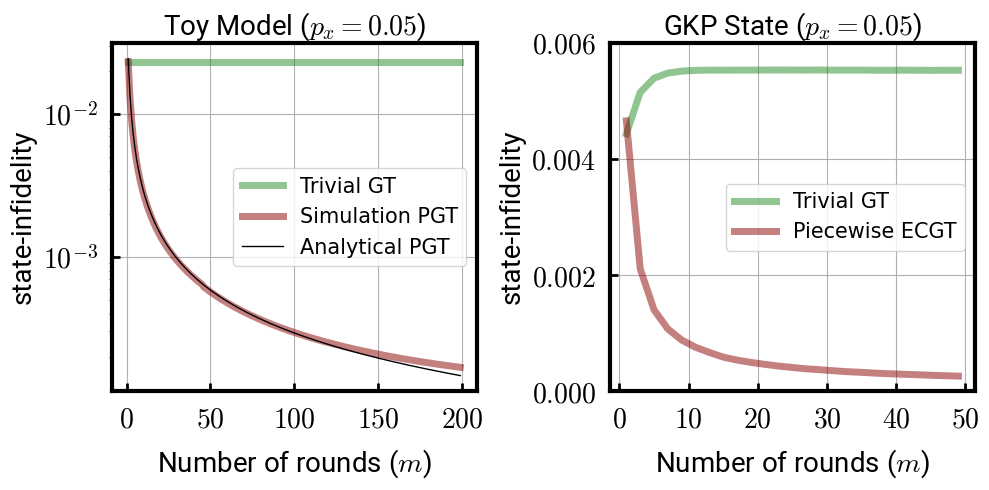

In [1072]:
GT=np.load("Paper_Data/GT.npz")["arr_0"]
P_ECGT=np.load("Paper_Data/P_ECGT.npz")["arr_0"]
trivial=np.load("Paper_Data/trivial.npz")["arr_0"]
sims=np.load("Paper_Data/simulation.npz")["arr_0"]
anal=np.load("Paper_Data/analytical.npz")["arr_0"]
m=np.linspace(1,len(GT),len(GT))
l=np.linspace(1,len(anal),len(anal))
fig, ax = plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(hspace=-0.5)
ax[1].plot(m[::2],GT[::2],"-",color="forestgreen",linewidth=5,alpha=0.5,label="Trivial GT")
ax[1].plot(m[::2],P_ECGT[::2],"-",color="darkred",linewidth=5,alpha=0.5,label=r"Piecewise ECGT")
ax[0].plot(l,[trivial[0]]*len(l),"-",color="forestgreen",linewidth=5,alpha=0.5,label=r"Trivial GT")
ax[0].plot(l,sims,"-",color="darkred",linewidth=5,alpha=0.5,label="Simulation PGT")
ax[0].plot(l,anal,"-",color="black",linewidth=1,alpha=1,label=r"Analytical PGT")
ax[0].legend(fontsize=15,loc="center right")
ax[1].legend(fontsize=15,loc="center right")
ax[0].set_yscale('log')
ax[0].set_yticks([10**(-2),10**(-3)],[r"$10^{-2}$",r"$10^{-3}$"],font=font,fontsize=20)
ax[1].set_yticks([0.000,0.002,0.004,0.006],[r"$0.000$",r"$0.002$",r"$0.004$",r"$0.006$"],fontsize=20)
ax[0].set_title("Toy Model ($p_x=0.05$)",font=font,fontsize=20)  
ax[1].set_title("GKP State ($p_x=0.05$)",font=font,fontsize=20)  
for i in range(2):
    ax[i].tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
    ax[i].set_xlabel(r'Number of rounds ($m$)',font=font,fontsize=20,labelpad=10)
    ax[i].tick_params(axis="x", direction='in', length=6, width=2,pad=10)
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(3)
    ax[i].grid()
ax[1].set_xticks([0,10,20,30,40,50],[r"$0$",r"$10$",r"$20$",r"$30$",r"$40$",r"$50$"],fontsize=20)
ax[0].set_xticks([0,50,100,150,200],[r"$0$",r"$50$",r"$100$",r"$150$",r"$200$"],fontsize=20)
ax[0].set_ylabel(r"state-infidelity",fontsize=20,font=font)
ax[1].set_ylabel(r"state-infidelity",fontsize=20,font=font)
fig.tight_layout() 
plt.savefig('Paper_Figures/GKP_single_gates.pdf',bbox_inches='tight',dpi=300,transparent=True)

### Quantum Phase Estimation

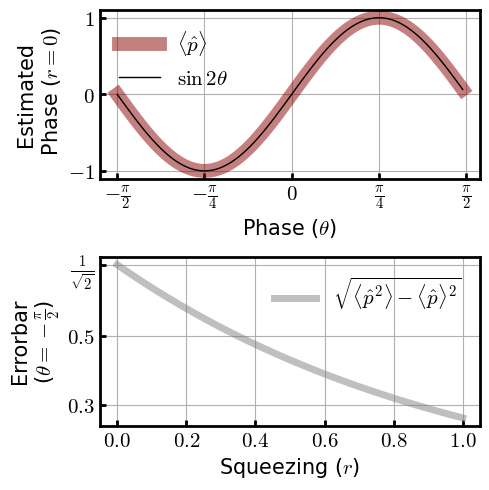

In [53]:
#Error in determining the phase with respect to squeezing
fontsize=15
phase=np.load("Paper_Data/phase_est1.npz")["arr_0"]
thet=np.load("Paper_Data/angle1.npz")["arr_0"]
err=np.load("Paper_Data/std1.npz")["arr_0"]
sq=np.linspace(0,1,100)
fig, ax = plt.subplots(2,1,figsize=(5,5))
ax[0].plot(np.array(thet),phase,color="darkred",linewidth=10,alpha=0.5,label=r"$\langle \hat p\rangle$")
ax[0].plot(np.array(thet),np.sin(2*thet),color="black",linewidth=1,alpha=1,label=r"$\sin{2\theta}$")
ax[1].plot(sq,err,color="gray",linewidth=5,alpha=0.5,label=r"$\sqrt{\langle {\hat p}^2\rangle-\langle \hat p\rangle^2}$")
for i in range(2):
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(2)
    ax[i].tick_params(axis="x", direction='in', length=4, width=2)
    ax[i].tick_params(axis="y", direction='in', length=4, width=2)
    ax[i].grid()
ax[0].legend(loc='upper left',prop={'size': 15},frameon=False)
ax[1].legend(loc='upper right',prop={'size': 15},frameon=False)
ax[0].set_xticks([np.pi/2,np.pi/4,0,-np.pi/4,-np.pi/2],[r"$\frac{\pi}{2}$",r"$\frac{\pi}{4}$",r"$0$",r"$-\frac{\pi}{4}$",r"$-\frac{\pi}{2}$"], fontsize=fontsize)
ax[0].set_xlabel(r"Phase ($\theta$)", weight="medium", fontsize=15)
ax[1].set_xlabel(r"Squeezing ($r$)", weight="medium", fontsize=15)
ax[0].set_ylabel(r"Estimated"+"\n"+" Phase ($r=0$)", weight="medium", fontsize=15)
ax[1].set_ylabel(r"Errorbar"+"\n"+r"($\theta=-\frac{\pi}{2}$)", weight="medium", fontsize=15)
ax[0].set_yticks([-1,0,1],[r"$-1$",r"$0$",r"$1$"], fontsize=15)
ax[1].set_yticks([np.sqrt(1/2),0.5,0.3],[r"$\frac{1}{\sqrt{2}}$",r"$0.5$",r"$0.3$"], fontsize=15)
ax[1].set_xticks([0.0,0.2,0.4,0.6,0.8,1.0],[r"$0.0$",r"$0.2$",r"$0.4$",r"$0.6$",r"$0.8$",r"$1.0$"], fontsize=15)
fig.tight_layout() 
plt.savefig('Paper_Figures/Phase_estimation.pdf',bbox_inches='tight',dpi=300,transparent=False)
plt.show()

### Four-legged cat states (BB1)

/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_91008/1651195206.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


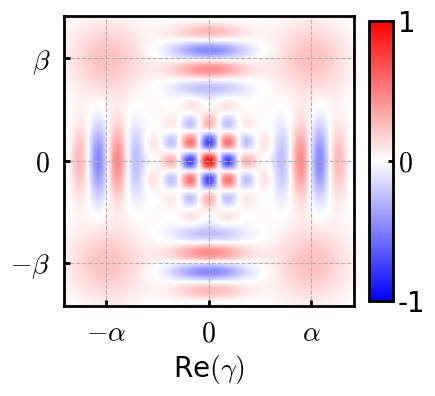

In [173]:
#State=log0_finite6.ptrace(0).unit()
#State=finalp.ptrace(1).unit()
#State=statep.ptrace(1).unit()
#State=eigenstat[-2]
alpha=2
State1=(coherent(Ncav,alpha+1j*alpha)+coherent(Ncav,-alpha+1j*alpha)+coherent(Ncav,-1j*alpha+alpha)+coherent(Ncav,-1j*alpha-alpha)).unit()
#State1=ket2dm((coherent(Ncav,alpha+1j*alpha)+coherent(Ncav,alpha-1j*alpha)).unit())+ket2dm((coherent(Ncav,-alpha+1j*alpha)+coherent(Ncav,-alpha-1j*alpha)).unit())
extent=4
xvec = np.linspace(-extent,extent,200)
W = wigner(State1,xvec,xvec) * np.pi
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
vmax=1
vmin=-1

p = ax.imshow(W, origin='lower', extent=[-4,4,-4,4], cmap='bwr',vmin=vmin,vmax=vmax)

for axis in ['top','bottom','left','right'] :
        ax.spines[axis].set_linewidth(2)
ax.tick_params(axis="x", direction='in', length=4, width=2,pad=10)
ax.tick_params(axis="y", direction='in', length=4, width=2,pad=10)
ax.set_xticks([-alpha*np.sqrt(2), 0, alpha*np.sqrt(2)],[r"$-\alpha$", r"$0$",r"$\alpha$"],fontsize=20)
ax.set_yticks([-alpha*np.sqrt(2), 0, alpha*np.sqrt(2)],[r"$-\beta$", r"$0$",r"$\beta$"],fontsize=20)
ax.grid(linestyle='--')

ax.set_xlabel(r"Re$(\gamma)$", weight="medium", fontsize=20)

#ax.set_ylabel(r"Im$(\gamma)$", weight="medium", fontsize=20)
cbaxes = fig.add_axes([0.7, 0.25, 0.03,0.7]) 
cbar   = plt.colorbar(p, fraction=0.046, pad=0.04, cax=cbaxes)
cbar.set_ticks([vmin, 0, vmax])
cbar.ax.tick_params(direction='in', width=2)
cbar.set_ticklabels([str(vmin), r'$0$', str(vmax)])
cbar.outline.set_color('k')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=20)
fig.tight_layout()
plt.savefig('Paper_Figures/4-legged-1.pdf',bbox_inches='tight',dpi=300,transparent=False)
plt.show()

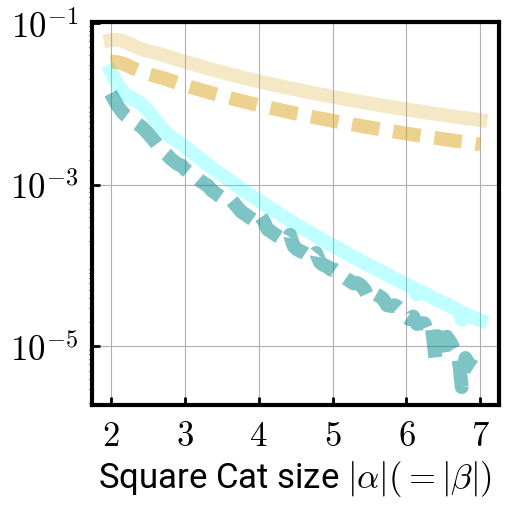

In [49]:
fail_prob1=np.load("Paper_Data/4_cat_sym_b.npz")["arr_0"][:,0]
fail_prob2=np.load("Paper_Data/4_cat_sym.npz")["arr_0"][:,0]
reset_fid1=np.load("Paper_Data/4_cat_sym_b.npz")["arr_0"][:,1]
reset_fid2=np.load("Paper_Data/4_cat_sym.npz")["arr_0"][:,1]
alph=np.linspace(2,7,100)
fig,ax=plt.subplots(1,1,figsize=(6,6))
gcr_1,=ax.plot(alph,fail_prob2,"-",color="goldenrod",linewidth=10,alpha=0.25,label=r"$\mathcal{P}(\mathrm{fail})$")
bb_1,=ax.plot(alph,fail_prob1,"-",color="cyan",linewidth=10,alpha=0.25,label=r"$\mathcal{P}_\mathrm{BB1}(\mathrm{fail})$")
#ax.plot(alph,succ_fid,color="blue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{GCR,s}$")
#ax.plot(alph_b,succ_b,"--",color="darkblue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{BB1,s}$")
gcr_2,=ax.plot(alph,reset_fid2,"--",color="goldenrod",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-\mathcal{F}$")
bb_2,=ax.plot(alph,reset_fid1,"--",color="darkcyan",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-\mathcal{F}_\mathrm{BB1}$")
ax.set_yscale('log')
#ax.legend(loc='lower left',fontsize = 30)
ax.set_xlabel(r'Square Cat size $|\alpha|(=|\beta|)$',fontsize=25,font=font)
ax.set_yticks([0.1,0.001,0.00001],[r"$10^{-1}$",r"$10^{-3}$",r"$10^{-5}$"],font=font,fontsize=25)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
ax.set_xticks([2,3,4,5,6,7],[r"$2$",r"$3$",r"$4$",r"$5$",r"$6$",r"$7$"],fontsize=25)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
plt.grid()
fig.tight_layout(pad=4) 
#plt.title(r"Square Cat size $|\alpha|(=|\beta|)$",fontsize=40,pad=20)
plt.savefig('Paper_Figures/Error_Analysis_4cat.pdf',bbox_inches='tight',dpi=300,transparent=True)

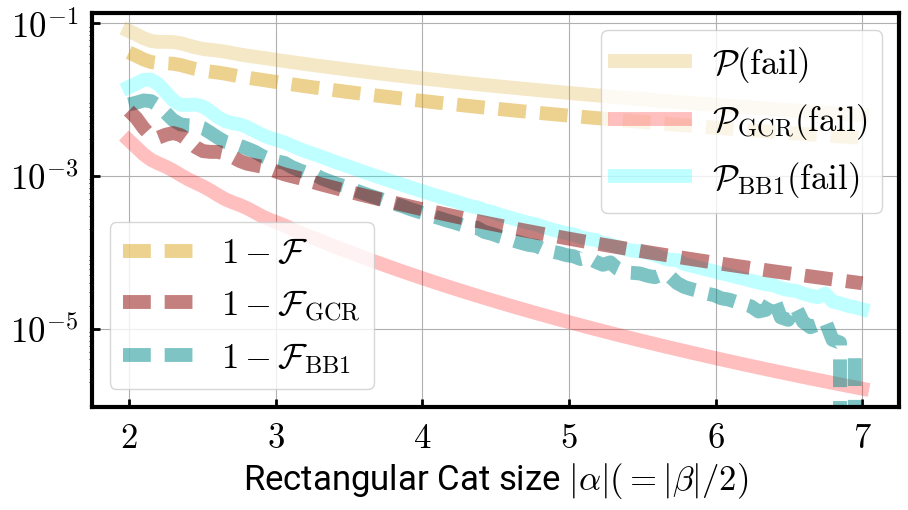

In [48]:
fail_prob=np.load("Paper_Data/4_cat_asym.npz")["arr_0"][:,0]
fail_prob1=np.load("Paper_Data/4_cat_asym_b.npz")["arr_0"][:,0]
fail_prob2=np.load("Paper_Data/4_cat_asym_gcr.npz")["arr_0"][:,0]
reset_fid=np.load("Paper_Data/4_cat_asym.npz")["arr_0"][:,1]
reset_fid1=np.load("Paper_Data/4_cat_asym_b.npz")["arr_0"][:,1]
reset_fid2=np.load("Paper_Data/4_cat_asym_gcr.npz")["arr_0"][:,1]
alph=np.linspace(2,7,100)
fig,ax=plt.subplots(1,1,figsize=(10,6))
no_corr_1,=ax.plot(alph,fail_prob,"-",color="goldenrod",linewidth=10,alpha=0.25,label=r"$\mathcal{P}(\mathrm{fail})$")
bb_1,=ax.plot(alph,fail_prob1,"-",color="cyan",linewidth=10,alpha=0.25,label=r"$\mathcal{P}_\mathrm{BB1}(\mathrm{fail})$")
gcr_1,=ax.plot(alph,fail_prob2,"-",color="red",linewidth=10,alpha=0.25,label=r"$\mathcal{P}_\mathrm{GCR}(\mathrm{fail})$")
#ax.plot(alph,succ_fid,color="blue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{GCR,s}$")
#ax.plot(alph_b,succ_b,"--",color="darkblue",linewidth=5,alpha=0.25,label=r"$1-\mathcal{F}_{BB1,s}$")
no_corr_2,=ax.plot(alph,reset_fid,"--",color="goldenrod",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-\mathcal{F}$")
bb_2,=ax.plot(alph,reset_fid1,"--",color="darkcyan",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-\mathcal{F}_\mathrm{BB1}$")
gcr_2,=ax.plot(alph,reset_fid2,"--",color="darkred",linewidth=10,dashes=(2, 1),alpha=0.5,label=r"$1-\mathcal{F}_\mathrm{GCR}$")
ax.set_yscale('log')
first_legend = ax.legend(handles=[no_corr_1,gcr_1,bb_1], loc='upper right',fontsize = 25)
second_legend = plt.legend(handles=[no_corr_2,gcr_2,bb_2], loc='lower left',fontsize = 25)
ax.add_artist(first_legend)
ax.set_xlabel(r'Rectangular Cat size $|\alpha|(=|\beta|/2)$',fontsize=25,font=font)
ax.set_yticks([0.1,0.001,0.00001],[r"$10^{-1}$",r"$10^{-3}$",r"$10^{-5}$"],font=font,fontsize=25)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
ax.set_xticks([2,3,4,5,6,7],[r"$2$",r"$3$",r"$4$",r"$5$",r"$6$",r"$7$"],fontsize=25)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
plt.grid()
fig.tight_layout(pad=4) 
plt.savefig('Paper_Figures/Rect_4cat.pdf',bbox_inches='tight',dpi=300,transparent=True)

/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_5883/266841585.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend(loc='upper right',prop={'size': 15},frameon=False)


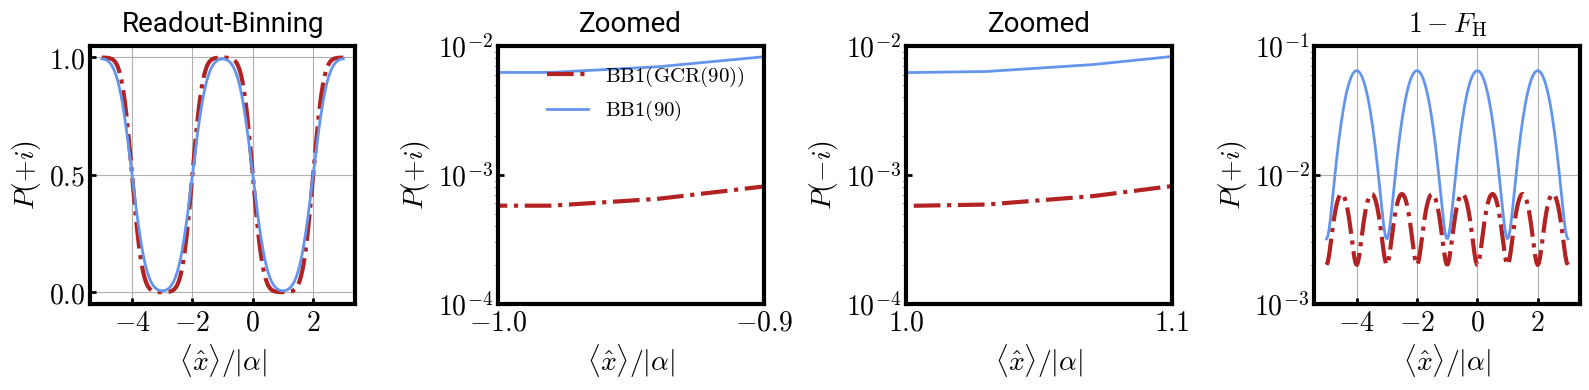

In [ ]:
#GCR_BB1 for , |\alpha|=\sqrt{\pi}/2

fontsize=20
sy=np.load("Paper_Data/GCR_BB1_alpha.npz")["arr_0"]
sy1=np.load("Paper_Data/BB1_alpha.npz")["arr_0"]
sfid=np.load("Paper_Data/GCR_BB1_alpha_fid.npz")["arr_0"]
sfid1=np.load("Paper_Data/BB1_alpha_fid.npz")["arr_0"]
alph1=((np.load("Paper_Data/GCR_BB1_err.npz")["arr_0"])*np.sqrt(np.pi)-np.sqrt(np.pi)/2)/(np.sqrt(np.pi)/2)
fig,ax=plt.subplots(1,4,figsize=(16,4))
ax[2].plot(alph1,np.array(sy),'-.',color="firebrick",linewidth=3)
ax[2].plot(alph1,np.array(sy1),color="cornflowerblue",linewidth=2)
ax[0].plot(alph1,sy,'-.',color="firebrick",linewidth=3)
ax[0].plot(alph1,sy1,color="cornflowerblue",linewidth=2)
ax[1].plot(alph1,1-np.array(sy),'-.',color="firebrick",linewidth=3,label=r'$\mathrm{BB1}(\mathrm{GCR}(90))$')
ax[1].plot(alph1,1-np.array(sy1),color="cornflowerblue",linewidth=2,label=r'$\mathrm{BB1}(90)$')
ax[3].plot(alph1,sfid,'-.',color="firebrick",linewidth=3)
ax[3].plot(alph1,sfid1,color="cornflowerblue",linewidth=2)
ax[1].set_xlim(-1,-0.9)
ax[2].set_xlim(1,1.1)
for i in range(4):
    if i!=0:
        ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$\langle \hat x\rangle/|\alpha|$',font=font,fontsize=fontsize)
    if i!=2:
        ax[i].set_ylabel(r'$P(+i)$',font=font,fontsize=fontsize)
    else:
        ax[i].set_ylabel(r'$P(-i)$',font=font,fontsize=fontsize)
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(3)
    ax[i].tick_params(axis="x", direction='in', length=4, width=2)
    ax[i].tick_params(axis="y", direction='in', length=4, width=2)
    if i==0 or i==3:
        ax[i].set_xticks([-4,-2,0,2],[r"$-4$",r"$-2$",r"$0$",r"$2$"], fontsize=fontsize)
        ax[i].grid()
    else:
        ax[i].set_yticks([0.01,0.001,0.0001],[r"$10^{-2}$",r"$10^{-3}$",r"$10^{-4}$"], fontsize=fontsize)
        ax[i].set_ylim(0.0001,0.01)
        ax[i].legend(loc='upper right',prop={'size': 15},frameon=False)
ax[3].set_yticks([0.1,0.01,0.001],[r"$10^{-1}$",r"$10^{-2}$",r"$10^{-3}$"], fontsize=fontsize)
ax[0].set_yticks([1.0,0.5,0],[r"$1.0$",r"$0.5$",r"$0.0$"], fontsize=fontsize)
        
    
ax[1].set_xticks([-1.0,-0.9],[r"$-1.0$",r"$-0.9$"], fontsize=fontsize)
ax[2].set_xticks([1.0,1.1],[r"$1.0$",r"$1.1$"], fontsize=fontsize)

ax[1].set_title(r'Zoomed',font=font, fontsize=fontsize,pad=10)
ax[2].set_title(r'Zoomed',font=font, fontsize=fontsize,pad=10)
ax[3].set_title(r'$1-F_\mathrm{H}$',font=font, fontsize=fontsize,pad=10)
ax[0].set_title(r"Readout-Binning",font=font, fontsize=fontsize,pad=10)
fig.tight_layout() 
    
plt.savefig('Paper_Figures/GCR_BB1.pdf',bbox_inches='tight',dpi=300,transparent=True)

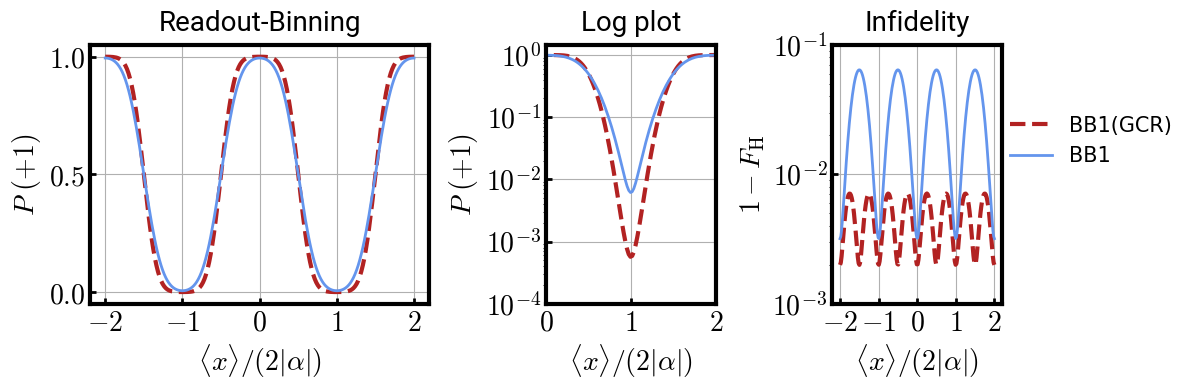

In [ ]:
#GCR_BB1 for , |\alpha|=\sqrt{\pi}/2

fontsize=20
sy=np.load("Paper_Data/GCR_BB1_alpha.npz")["arr_0"]
sy1=np.load("Paper_Data/BB1_alpha.npz")["arr_0"]
sfid=np.load("Paper_Data/GCR_BB1_alpha_fid.npz")["arr_0"]
sfid1=np.load("Paper_Data/BB1_alpha_fid.npz")["arr_0"]
alph1=(np.load("Paper_Data/GCR_BB1_err.npz")["arr_0"])
fig, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1, 1]})

ax[0].plot(alph1,sy,'--',color="firebrick",linewidth=3)
ax[0].plot(alph1,sy1,color="cornflowerblue",linewidth=2)
ax[1].plot(alph1,sy,'--',color="firebrick",linewidth=3)
ax[1].plot(alph1,sy1,color="cornflowerblue",linewidth=2)
ax[2].plot(alph1,sfid,'--',color="firebrick",linewidth=3,label=r'BB1(GCR)')
ax[2].plot(alph1,sfid1,color="cornflowerblue",linewidth=2,label=r'BB1')
ax[1].set_yscale("log")        
ax[1].set_xlim(0,2)
for i in range(3):
    if i!=0:
        ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$\langle x\rangle/(2|\alpha|)$',font=font,fontsize=fontsize)
    if i!=2:
        ax[i].set_ylabel(r'$P \ (+1)$',font=font,fontsize=fontsize)
    else:
        ax[i].set_ylabel(r'$1-F_\mathrm{H}$',font=font,fontsize=fontsize)
    for axis in ['top','bottom','left','right'] :
        ax[i].spines[axis].set_linewidth(3)
    ax[i].tick_params(axis="x", direction='in', length=4, width=2)
    ax[i].tick_params(axis="y", direction='in', length=4, width=2)
    ax[i].grid()
    if i!=1:
        ax[i].set_xticks([-2,-1,0,1,2],[r"$-2$",r"$-1$",r"$0$",r"$1$",r"$2$"], fontsize=fontsize)     
    else:
        ax[i].set_xticks([0,1,2],[r"$0$",r"$1$",r"$2$"], fontsize=fontsize)     
ax[1].set_yticks([1,0.1,0.01,0.001,0.0001],[r"$10^{0}$",r"$10^{-1}$",r"$10^{-2}$",r"$10^{-3}$",r"$10^{-4}$"], fontsize=fontsize)
ax[2].legend(loc=(1,0.5),prop={'size': 15},frameon=False)
ax[2].set_yticks([0.1,0.01,0.001],[r"$10^{-1}$",r"$10^{-2}$",r"$10^{-3}$"], fontsize=fontsize)
ax[0].set_yticks([1.0,0.5,0],[r"$1.0$",r"$0.5$",r"$0.0$"], fontsize=fontsize)
    
#ax[1].set_xticks([1.0,1.1],[r"$1.0$",r"$1.1$"], fontsize=fontsize)

ax[1].set_title(r'Log plot',font=font, fontsize=fontsize,pad=10)
ax[2].set_title(r'Infidelity',font=font, fontsize=fontsize,pad=10)
ax[0].set_title(r"Readout-Binning",font=font, fontsize=fontsize,pad=10)
fig.tight_layout() 
    
plt.savefig('Paper_Figures/GCR_BB1.pdf',bbox_inches='tight',dpi=300,transparent=True)

In [ ]:
#Fock states (#change Ncav to 50 before running below cells!)
z=np.pi/2
Opx0=tensor(sigmay(),-1j*z*pOp).expm()#z
Opx1=tensor(sigmax(),1j*1*xOp).expm()#(np.pi/4/z)
Opx2=tensor(sigmay(),-1j*(np.arctan(np.sinh(np.pi/2))/z)*pOp).expm()#(np.arctan(np.sinh(np.pi/2))/2/z)
Op=Opx0
state=(Opx2*Opx1*Op*tensor(g,basis(Ncav,0))).unit()
statef=tensor(e,basis(Ncav,1))

eigenvals,eigenstat=xOp.eigenstates()
eigenvals1,eigenstat1=pOp.eigenstates()
axis_x=[]
psi=[]
axis_p=[]
psi1=[]
psi2=[]
psi3=[]
sx=[]
sy=[]
sz=[]
ang=[] 
trac=[]
State=ket2dm(state)
for i in range(len(eigenstat)):
    Op1=tensor(qeye(2),ket2dm(eigenstat[i]))
    new_State=Op1*State*Op1.dag()
    mod_Qubit=new_State.ptrace(0).unit()
    mod_State=new_State.ptrace(1).unit()
    psi.append(expect(tensor(ket2dm(eigenstat[i])),State.ptrace(1)))
    psi3.append(expect(tensor(ket2dm(eigenstat1[i])),State.ptrace(1)))#momentum wave function
    axis_x.append(eigenvals[i])
    axis_p.append(eigenvals1[i])
    sx.append(expect(sigmax(),mod_Qubit))
    sy.append(expect(sigmay(),mod_Qubit))
    sz.append(expect(sigmaz(),mod_Qubit))
    #sz.append(expect(tensor(qeye(Ncav),ket2dm((e).unit())),State))

c=1/np.trapz(psi,eigenvals)
psi=c*np.array(psi)    
c3=1/np.trapz(psi3,eigenvals1)
psi3=c3*np.array(psi3)    

/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_91008/2256128708.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(pad=3)


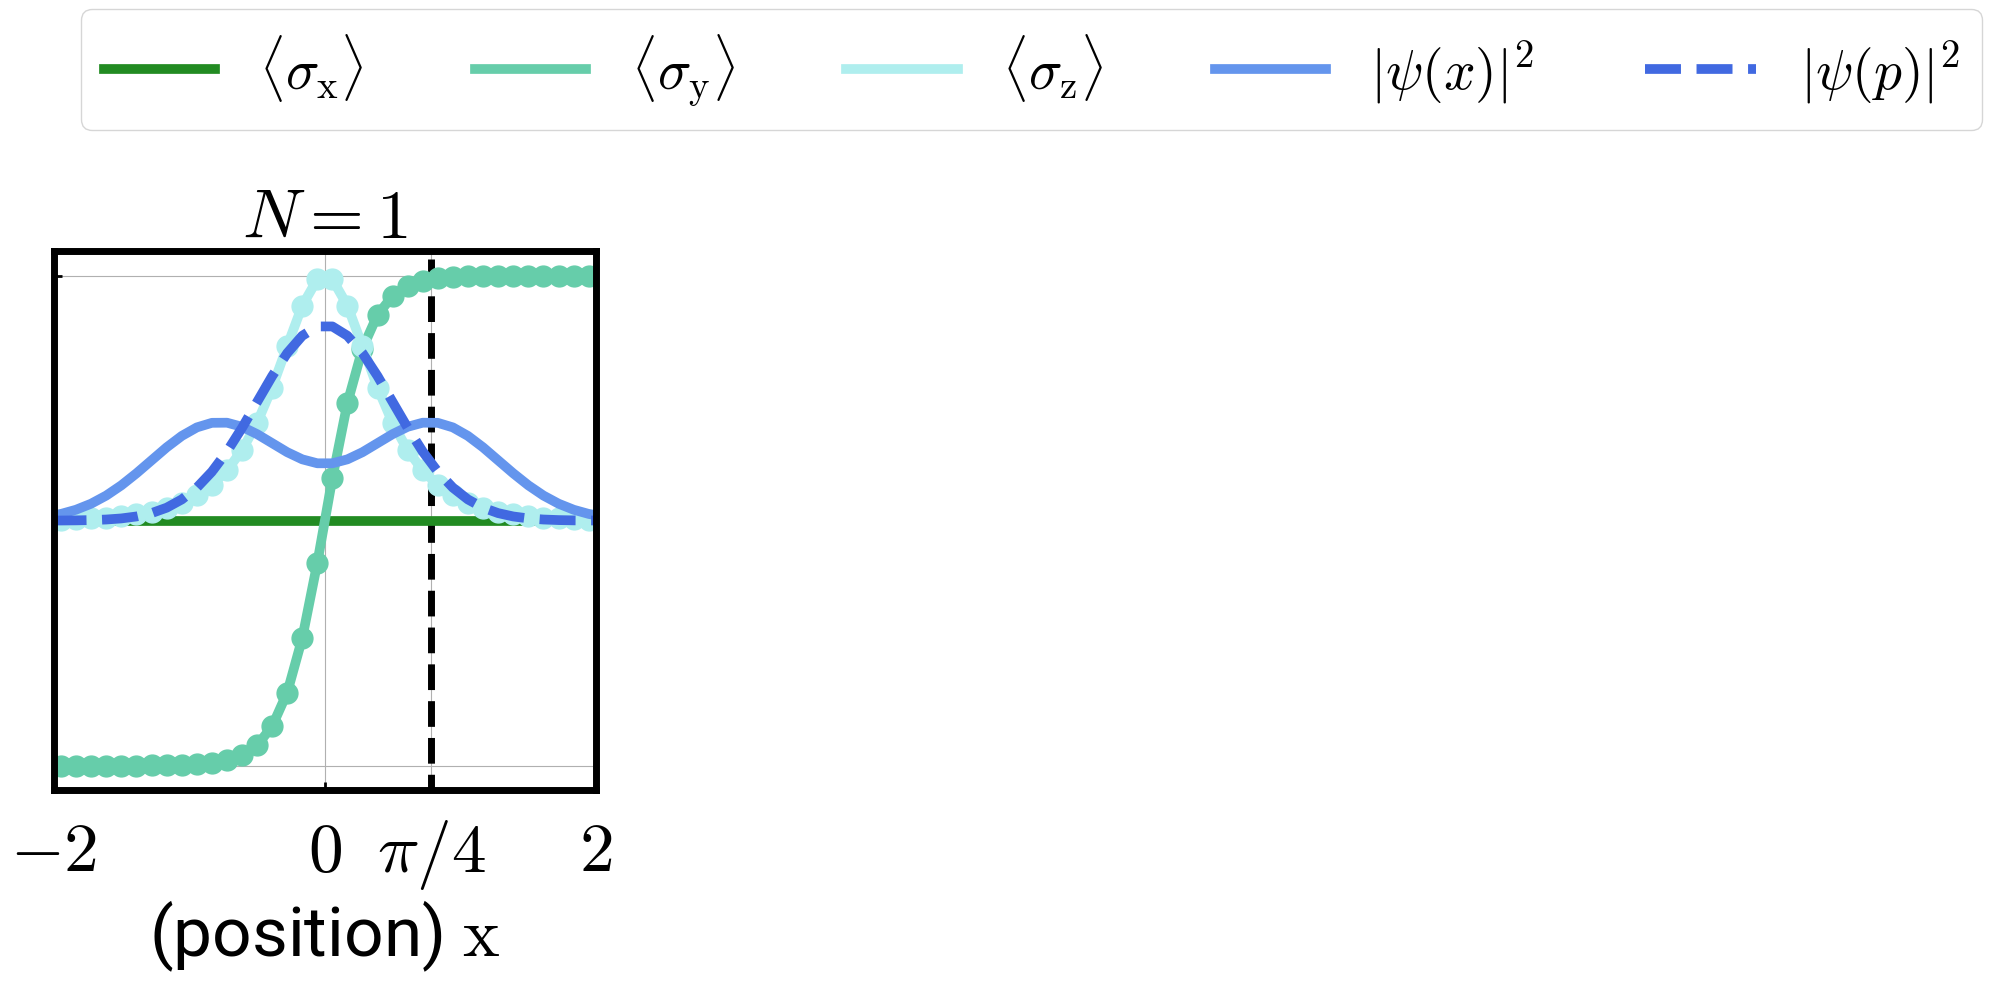

In [130]:
fig,ax=plt.subplots(1,1,figsize=(7,7))
z=np.pi/4
ax.plot([z]*Ncav,axis_p,'--',color="black",linewidth=5)#gives expectation of sigmaz
s_x,=ax.plot(axis_x,sx,"-",color="forestgreen",linewidth=7,label=r"$\langle\sigma_\mathrm{x}\rangle$")
s_y,=ax.plot(axis_x,sy,"-",color="mediumaquamarine",linewidth=7,label=r"$\langle\sigma_\mathrm{y}\rangle$")
s_y,=ax.plot(axis_x,[np.tanh(np.pi*x) for x in axis_x],"o",markersize=15,color="mediumaquamarine")
s_z,=ax.plot(axis_x,sz,"-",color="paleturquoise",linewidth=7,label=r"$\langle\sigma_\mathrm{z}\rangle$")
s_z,=ax.plot(axis_x,[1/np.cosh(np.pi*x) for x in axis_x],"o",markersize=15,color="paleturquoise",linewidth=5)
psi_1,=ax.plot(axis_x,psi,"-",color="cornflowerblue",linewidth=7,label=r"$|\psi(x)|^2$")
psi_2,=ax.plot(axis_p,psi3,"--",color="royalblue",linewidth=7,label=r"$|\psi(p)|^2$")

ax.set_xlim(-2,2)
ax.set_ylim(-1,1.1)
#ax.set_xticks(np.arange(-3, 4,1),fontsize=15)
#ax.set_yticks(np.arange(-1,1.1,0.5),fontsize=15)
ax.legend(bbox_to_anchor=(0, 1.50),loc='upper left',fontsize =40,ncol=5)

ax.set_xlabel(r"(position) $\mathrm{x}$",font=font,fontsize=50)
ax.set_yticks([1,0,-1],[r"",r"",r""],fontsize=40)
ax.set_ylim(-1.1,1.1)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=10)
ax.set_xticks([-2,0,np.pi/4,2],[r"$-2$",r"$0$",r"$\pi/4$",r"$2$"],fontsize=50)
ax.set_title(r"$N=1$",font=font,fontsize=50)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=20)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(5)
ax.grid()
fig.tight_layout(pad=3) 
#plt.savefig('Paper_Figures/Fock1.pdf',bbox_inches='tight',dpi=300,transparent=True)

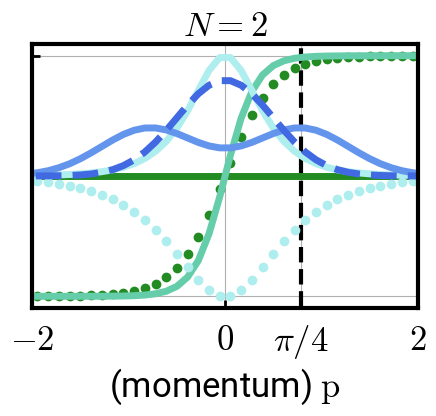

In [131]:
fig,ax=plt.subplots(1,1,figsize=(5,4.8))
z=np.pi/4
ax.plot([z]*Ncav,axis_p,'--',color="black",linewidth=3)#gives expectation of sigmaz
s_x,=ax.plot(axis_p,sx,"-",color="forestgreen",linewidth=5,label=r"$\langle\sigma_\mathrm{x}\rangle$")
s_x,=ax.plot(axis_p,[np.tanh(2*p) for p in axis_p],"o",color="forestgreen")
s_y,=ax.plot(axis_p,sy,"-",color="mediumaquamarine",linewidth=5,label=r"$\langle\sigma_\mathrm{y}\rangle$")
s_z,=ax.plot(axis_p,sz,"-",color="paleturquoise",linewidth=5,label=r"$\langle\sigma_\mathrm{z}\rangle$")
s_z,=ax.plot(axis_p,[-1/np.cosh(2*p) for p in axis_p],"o",color="paleturquoise",linewidth=5)
psi_1,=ax.plot(axis_x,psi,"-",color="cornflowerblue",linewidth=5,label=r"$|\psi(x)|^2$")
psi_2,=ax.plot(axis_p,psi3,"--",color="royalblue",linewidth=5,label=r"$|\psi(p)|^2$")

ax.set_xlim(-2,2)
ax.set_ylim(-1,1.1)

ax.set_ylim(-1.1,1.1)
ax.set_xlabel(r"(momentum) $\mathrm{p}$",font=font,fontsize=25)
ax.set_yticks([1,0,-1],[r"",r"",r""],fontsize=25)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=5)
ax.set_xticks([-2,0,np.pi/4,2],[r"$-2$",r"$0$",r"$\pi/4$",r"$2$"],fontsize=25)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
ax.set_title(r"$N=2$",font=font,fontsize=25)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
ax.grid()
fig.tight_layout(pad=3) 
#plt.savefig('Paper_Figures/Fock2.pdf',bbox_inches='tight',dpi=300,transparent=True)

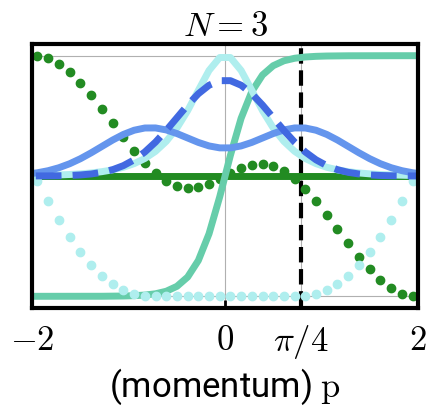

In [132]:
fig,ax=plt.subplots(1,1,figsize=(5,4.8))
z=np.pi/4
a=(np.arctan(np.sinh(np.pi/2))/z)
ax.plot([z]*Ncav,axis_p,'--',color="black",linewidth=3)#gives expectation of sigmaz
s_x,=ax.plot(axis_p,sx,"-",color="forestgreen",linewidth=5,label=r"$\langle\sigma_\mathrm{x}\rangle$")
s_x,=ax.plot(axis_p,[-np.sin(2*z*p)/np.cosh(2*p)+np.cos(2*z*p)*np.tanh(2*p) for p in axis_p],"o",color="forestgreen")
s_y,=ax.plot(axis_p,sy,"-",color="mediumaquamarine",linewidth=5,label=r"$\langle\sigma_\mathrm{y}\rangle$")
s_z,=ax.plot(axis_p,sz,"-",color="paleturquoise",linewidth=5,label=r"$\langle\sigma_\mathrm{z}\rangle$")
s_z,=ax.plot(axis_p,[-np.cos(2*z*p)/np.cosh(2*p)-np.sin(2*z*p)*np.tanh(2*p) for p in axis_p],"o",color="paleturquoise",linewidth=5)
psi_1,=ax.plot(axis_x,psi,"-",color="cornflowerblue",linewidth=5,label=r"$|\psi(x)|^2$")
psi_2,=ax.plot(axis_p,psi3,"--",color="royalblue",linewidth=5,label=r"$|\psi(p)|^2$")

ax.set_xlim(-2,2)
ax.set_ylim(-1,1.1)

ax.set_ylim(-1.1,1.1)
ax.set_xlabel(r"(momentum) $\mathrm{p}$",font=font,fontsize=25)
ax.set_yticks([1,0,-1],[r"",r"",r""],fontsize=25)
ax.tick_params(axis="y", direction='in', length=6, width=2, which='major',pad=5)
ax.set_xticks([-2,0,np.pi/4,2],[r"$-2$",r"$0$",r"$\pi/4$",r"$2$"],fontsize=25)
ax.tick_params(axis="x", direction='in', length=6, width=2,pad=10)
ax.set_title(r"$N=3$",font=font,fontsize=25)
for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(3)
ax.grid()
fig.tight_layout(pad=3) 
#plt.savefig('Paper_Figures/Fock3.pdf',bbox_inches='tight',dpi=300,transparent=True)

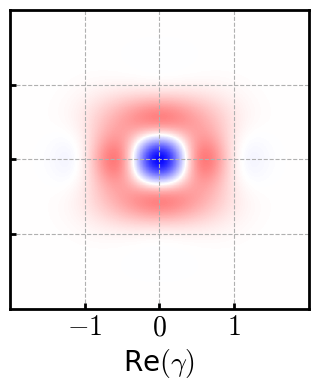

In [184]:
State1=state.ptrace(1).unit()
extent=4
xvec = np.linspace(-extent,extent,200)
W = wigner(State1,xvec,xvec) * np.pi
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
vmax=1
vmin=-1

p = ax.imshow(W, origin='lower', extent=[-2,2,-2,2], cmap='bwr',vmin=vmin,vmax=vmax)

for axis in ['top','bottom','left','right'] :
        ax.spines[axis].set_linewidth(2)
ax.tick_params(axis="x", direction='in', length=4, width=2)
ax.tick_params(axis="y", direction='in', length=4, width=2)
ax.set_xticks([-1, 0, 1],["$-1$", "$0$","$1$"], fontsize=20)
#ax.set_yticks([-1, 0, 1],["$-1$", "$0$","$1$"], fontsize=20)
ax.set_yticks([-1, 0, 1],["", "",""], fontsize=20)
ax.grid(linestyle='--')

ax.set_xlabel(r"Re$(\gamma)$", weight="medium", fontsize=20)
"""
ax.set_ylabel(r"Im$(\gamma)$", weight="medium", fontsize=20)
cbaxes = fig.add_axes([0.15, 0.21, 0.03,0.7]) 
cbar   = plt.colorbar(p, fraction=0.46, pad=0.04, cax=cbaxes, location='left')
cbar.set_ticks([vmin, 0, vmax])
cbar.ax.tick_params(direction='in', width=2)
cbar.set_ticklabels([str(vmin), r'$0$', str(vmax)])
cbar.outline.set_color('k')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=20)
"""
fig.tight_layout()
plt.savefig('Paper_Figures/Fock3_Wigner.pdf',bbox_inches='tight',dpi=300,transparent=False)
plt.show()